# Imports and Loading data


In [197]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import download
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report,
    f1_score,
    recall_score,
    precision_score,
)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
%matplotlib inline

In [198]:
download("stopwords")
download("punkt")

[nltk_data] Downloading package stopwords to /Users/dpapp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dpapp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [199]:
dataFiles = [
    "600_trans.tsv",
    "601_trans.tsv",
    "603_trans_3.tsv",
    "604_trans.tsv",
    "614_trans.tsv",
]

data = None

for dataFile in dataFiles:
    print("Processing file: " + dataFile)

    data = pd.concat(
        [data, pd.read_csv("input/" + dataFile, sep="\t")], ignore_index=True
    )

Processing file: 600_trans.tsv
Processing file: 601_trans.tsv
Processing file: 603_trans_3.tsv
Processing file: 604_trans.tsv
Processing file: 614_trans.tsv


In [200]:
data.head(10)

name  \
0                                Course Introduction   
1                                    Business Ethics   
2  Introduction to Managerial Finance and Accounting   
3                         Introduction to Accounting   
4  Financial Statements - Income statements and r...   
5               Financial Statements - Balance sheet   
6                   Financial Statements - Cash Flow   
7  Analyzing Financial Statements and Financial P...   
8                                Analyzing Cash Flow   
9                           Cash and Profit Planning   

                                            features  \
0  In the video, the instructor of the course ENM...   
1  In this lecture on business ethics, the instru...   
2  In this video, the instructor introduces stude...   
3  In this video, students will learn about the i...   
4  In this video, the instructor introduces the i...   
5  In the video transcript for the course ENMA 60...   
6  In this video transcript, the instructor empha...   
7  The video introduces the concept of ratio anal...   
8  The key takeaway from this video is that analy...   
9  In this video, the instructor focuses on the i...   

                                          transcript  cluster  number  hours  \
0  Well, greetings and welcome to the first lectu...       24     1.0    1.0   
1  Greetings. Hello again. In this lecture, we'll...       25     2.0    1.0   
2  Well, hello again and welcome back. In this le...       26     3.0    1.0   
3  Greetings. In this lecture, we're going to cov...       26     3.1    1.0   
4  Greetings. In this lecture. We're going to beg...       26     3.2    1.0   
5  Greetings In this lecture. We're going to cont...       26     3.3    1.0   
6  Hello again. In this lecture, we're going to c...       26     3.4    1.0   
7  Greetings Over the last several lectures we've...       26     3.5    1.0   
8  Greetings. As we discussed in an earlier lectu...       27     4.0    1.0   
9  Hello again. In today's lecture, we're going t...       27     4.1    1.0   

  prefix  
0   CEFA  
1   CEFA  
2   CEFA  
3   CEFA  
4   CEFA  
5   CEFA  
6   CEFA  
7   CEFA  
8   CEFA  
9   CEFA

# Preprocessing


In [201]:
sw = set(stopwords.words("english"))

In [202]:
sw.add("module")
sw.add("course")
sw.add("problem")
sw.add("use")
sw.add("model")
sw.add("solution")
sw.add("solve")
sw.add("analyze")
sw.add("example")
sw.add("application")
sw.add("computer")
sw.add("computers")
sw.add("zero")
sw.add("one")
sw.add("two")
sw.add("three")
sw.add("four")
sw.add("five")
sw.add("six")
sw.add("seven")
sw.add("eight")
sw.add("nine")
sw.add("x")
sw.add("c")
sw.add("k")
sw.add("l")
sw.add("b")
sw.add("go")
sw.add("constraint")
sw.add("get")
sw.add("ok")
sw.add("uh")
sw.add("shift")
sw.add("see")
sw.add("give")
sw.add("take")
sw.add("right")
sw.add("know")
sw.add("want")
sw.add("may")
sw.add("way")
sw.add("say")
sw.add("let")
sw.add("thing")
sw.add("look")
sw.add("need")
sw.add("would")
sw.add("try")
sw.add("back")
sw.add("also")
sw.add("must")
sw.add("okay")
sw.add("talk")
sw.add("well")
sw.add("like")
sw.add("basically")
sw.add("maybe")

In [203]:
data["combined"] = (
    "Title: "
    + data.name.str.strip()
    + "; Description: "
    + data.features.str.strip()
    + "; Transcript: "
    + data.transcript.str.strip()
)

In [204]:
def remove_stopwords(text):
    filtered_sentence = [w for w in text if not w in sw]
    return " ".join(filtered_sentence)

In [205]:
import string

# lowercase all words in the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: x.lower())

# remove newline characters from the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: x.replace("\n", " "))

# remove punctuation from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: x.translate(str.maketrans("", "", string.punctuation))
)

# remove numbers from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: x.translate(str.maketrans("", "", string.digits))
)

# tokenize the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: word_tokenize(x))

# remove stopwords from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: [word for word in x if word not in sw]
)

In [206]:
w2v = data.copy()

# Embedding Models


## Word2Vec


In [207]:
word2vec = Word2Vec(
    sentences=w2v["combined"].values, min_count=3, sg=1, window=15, workers=8
)

In [208]:
for index, word in enumerate(word2vec.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(word2vec.wv.index_to_key)} is {word}")

word #0/6856 is going
word #1/6856 is project
word #2/6856 is time
word #3/6856 is thats
word #4/6856 is people
word #5/6856 is point
word #6/6856 is value
word #7/6856 is cost
word #8/6856 is lets
word #9/6856 is cash


In [209]:
word2vec.wv.most_similar("finance")

[('managerial', 0.8351390361785889),
 ('accounting', 0.7489444613456726),
 ('pertains', 0.7284511923789978),
 ('enterprise', 0.7015854120254517),
 ('namely', 0.6918464303016663),
 ('distinction', 0.6912567019462585),
 ('categories', 0.6890041828155518),
 ('partnership', 0.6847407221794128),
 ('pertain', 0.6808439493179321),
 ('societys', 0.6804496645927429)]

In [210]:
print(
    f"Word 'fiance' appeared {word2vec.wv.get_vecattr('finance', 'count')} times in the training corpus.\nThe most similar words are:\n{word2vec.wv.most_similar('finance')[0:3]}\n"
)
print(
    f"Word 'programming' appeared {word2vec.wv.get_vecattr('programming', 'count')} times in the training corpus.\nThe most similar words are:\n{word2vec.wv.most_similar('programming')[0:3]}\n"
)
print(
    f"Word 'algebra' appeared {word2vec.wv.get_vecattr('algebra', 'count')} times in the training corpus.\nThe most similar words are:\n{word2vec.wv.most_similar('algebra')[0:3]}\n"
)

Word 'fiance' appeared 63 times in the training corpus.
The most similar words are:
[('managerial', 0.8351390361785889), ('accounting', 0.7489444613456726), ('pertains', 0.7284511923789978)]

Word 'programming' appeared 374 times in the training corpus.
The most similar words are:
[('linear', 0.8316632509231567), ('integer', 0.7877029776573181), ('modeling', 0.7841859459877014)]

Word 'algebra' appeared 7 times in the training corpus.
The most similar words are:
[('modular', 0.8810620903968811), ('exponent', 0.8612160086631775), ('tabulated', 0.8600714206695557)]



In [211]:
emb_df = pd.DataFrame(
    [word2vec.wv.get_vector(str(n)) for n in word2vec.wv.key_to_index],
    index=word2vec.wv.key_to_index,
)
print(emb_df.shape)
emb_df.head()

(6856, 100)


0         1         2         3         4         5         6   \
going   -0.023861  0.273218 -0.300859 -0.056521  0.047144 -0.082569 -0.174023   
project -0.601884  0.510470 -0.166821 -0.161038  0.230792 -0.027827  0.087435   
time    -0.083167 -0.035901 -0.022305 -0.064658  0.162338  0.052201 -0.418095   
thats   -0.010759  0.217973 -0.105209  0.021080 -0.032878  0.094718 -0.206044   
people  -0.102105  0.264195 -0.046071 -0.173402  0.103678 -0.077916 -0.224159   

               7         8         9   ...        90        91        92  \
going   -0.104647 -0.064112 -0.301624  ...  0.392719  0.109605 -0.173089   
project  0.276973 -0.212485 -0.177676  ...  0.117767 -0.343878 -0.447180   
time    -0.375629 -0.372202 -0.168021  ...  0.109801  0.066898 -0.325096   
thats   -0.159804 -0.124107 -0.388491  ...  0.140098  0.258492 -0.234345   
people  -0.012213 -0.301860 -0.366134  ...  0.166944  0.015462  0.067658   

               93        94        95        96        97        98        99  
going    0.213015  0.323116  0.104964  0.245351 -0.159531 -0.034520 -0.367265  
project  0.126319  0.053694 -0.117739  0.214945 -0.325323 -0.454925 -0.223473  
time     0.255005  0.269832 -0.290419  0.228366  0.023786 -0.097678  0.118478  
thats    0.189938 -0.000223 -0.175348  0.385973 -0.169120  0.182000 -0.247870  
people  -0.138859  0.089526 -0.178190  0.390646  0.055784  0.309259 -0.507434  

[5 rows x 100 columns]

In [212]:
emb_df.to_csv("output/w2v_embeddings.tsv", index=True, sep="\t", header=False)

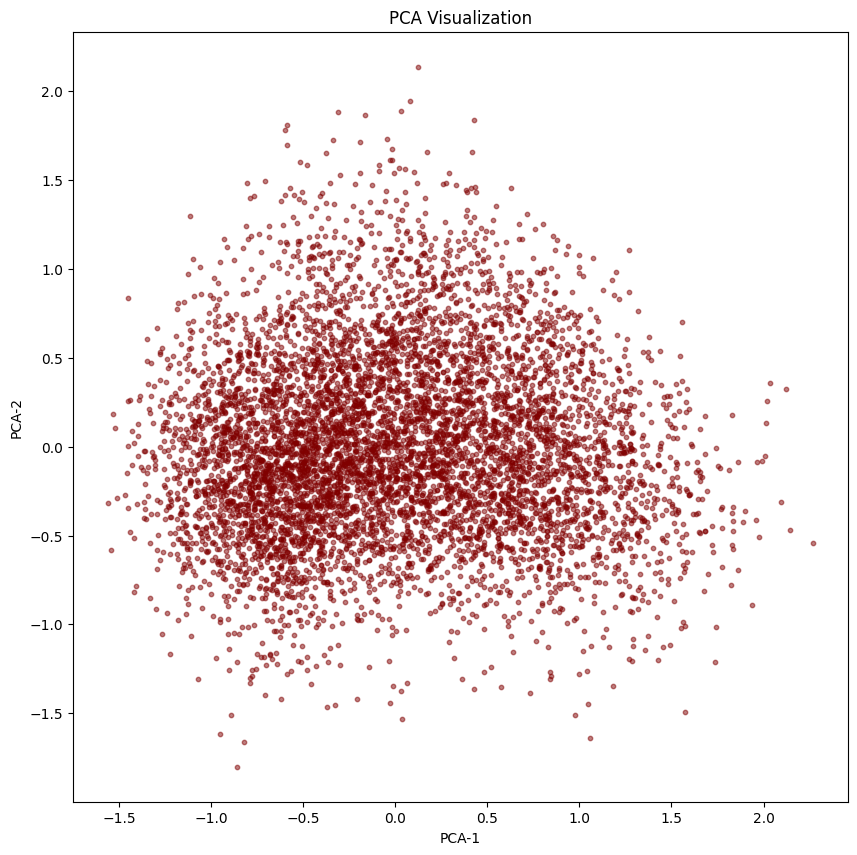

In [213]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = pd.DataFrame(pca_mdl, columns=["x", "y"], index=emb_df.index)

fig = plt.figure(figsize=(10, 10))

plt.scatter(x=emb_df_PCA["x"], y=emb_df_PCA["y"], s=10, color="maroon", alpha=0.5)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PCA Visualization")
plt.plot()
plt.show()

In [214]:
tsne = TSNE(n_components=2, random_state=42, perplexity=16, learning_rate=10)

tsne_results = tsne.fit_transform(emb_df)

tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])

tsne_df["label"] = emb_df.index

tsne_df.head()

x          y    label
0  -2.772253  -5.823149    going
1  -9.249420  10.610981  project
2   2.778280  -6.695611     time
3  12.374627 -12.422426    thats
4 -16.318823  -9.288565   people

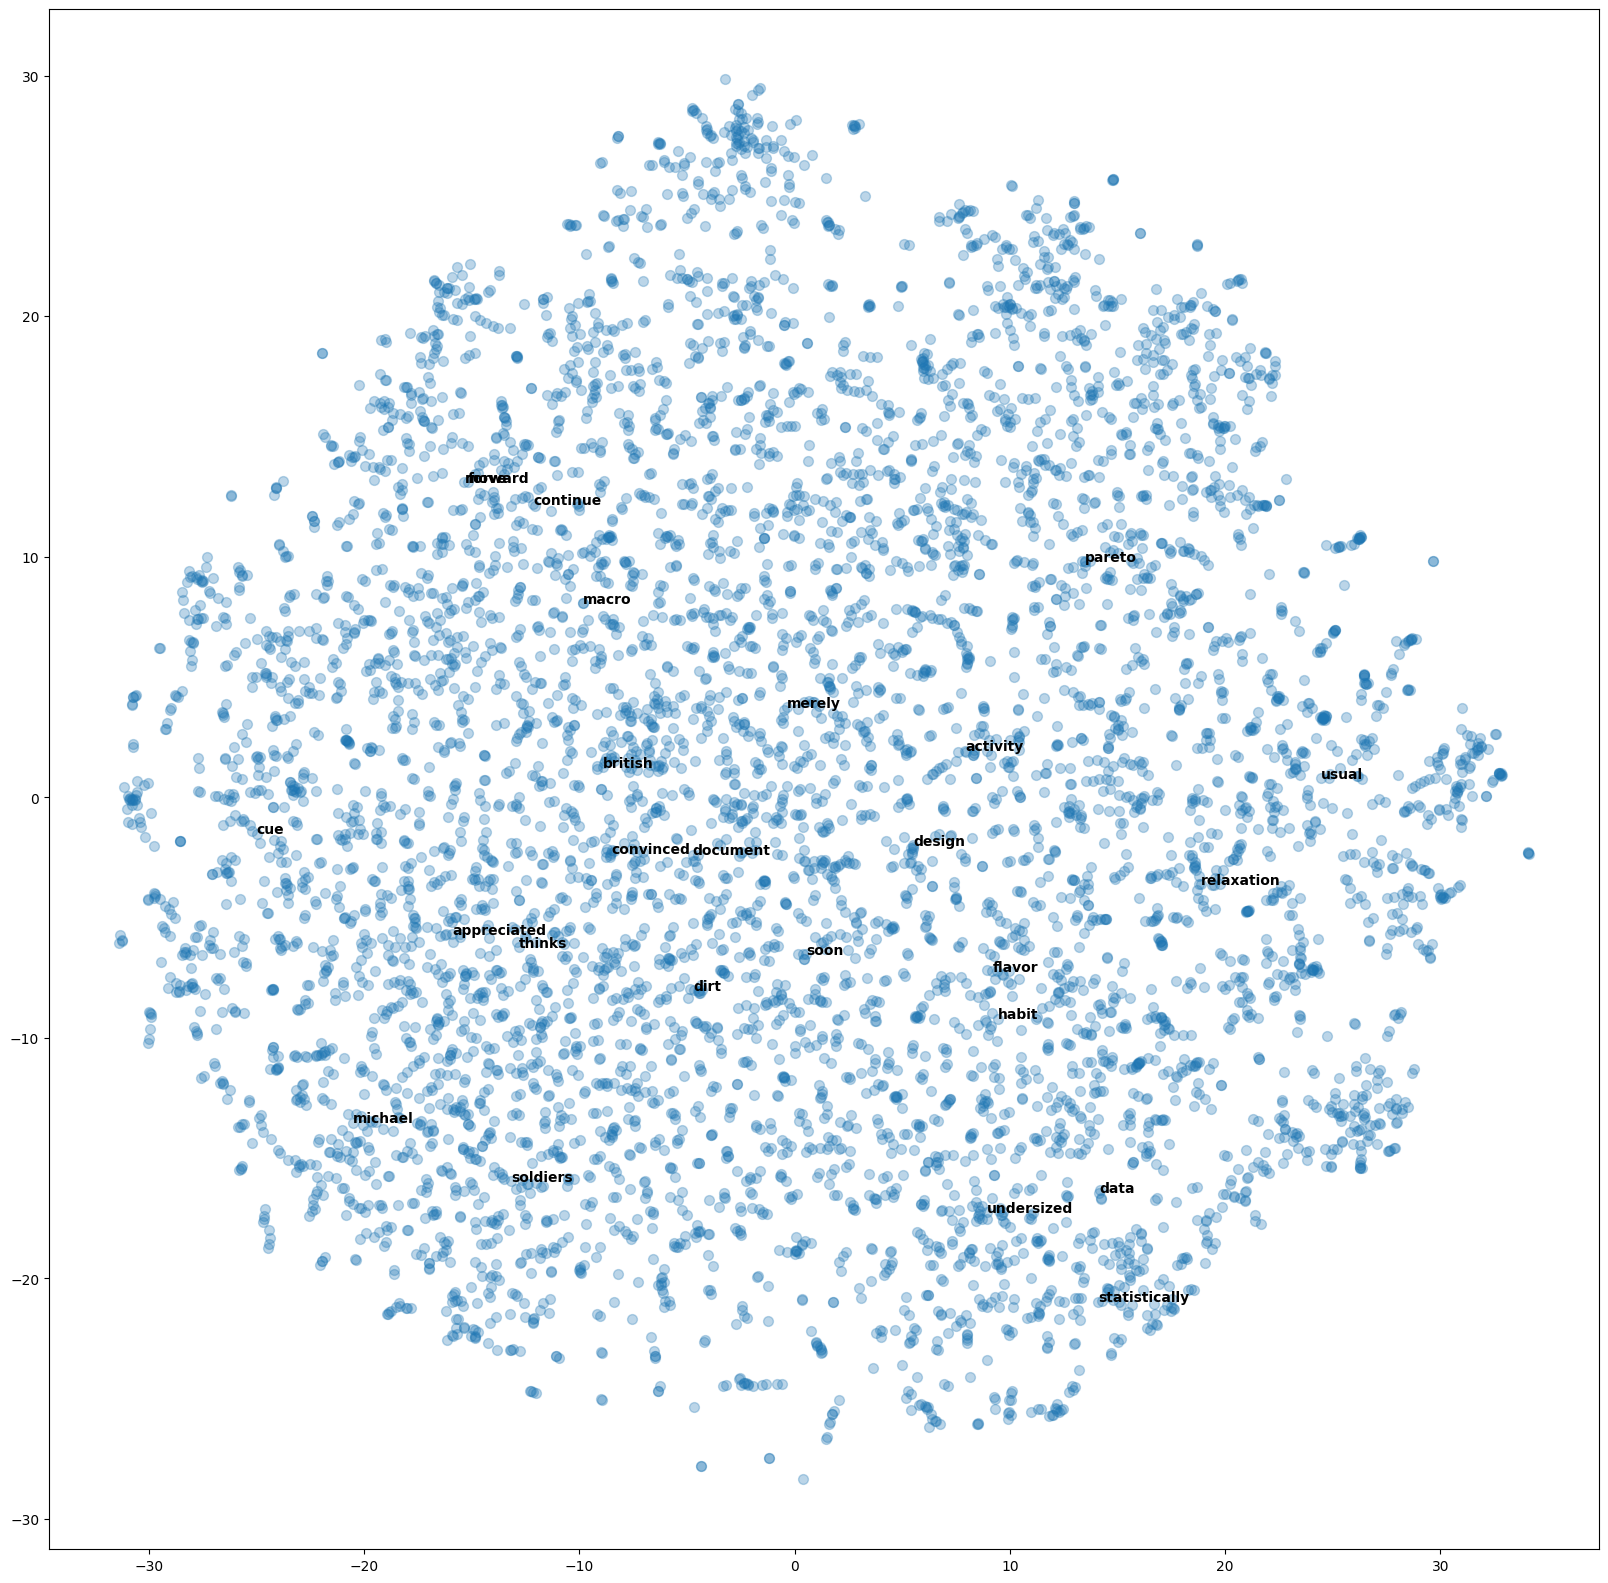

In [215]:
plt.figure(figsize=(20, 20))
plt.scatter(tsne_df.x, tsne_df.y, s=50, alpha=0.3)

annot_array = np.random.choice(tsne_df.index, 25, replace=False)

for i in annot_array:
    plt.text(
        s=tsne_df.label[i],
        x=tsne_df.x[i],
        y=tsne_df.y[i],
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )

plt.show()

## Doc2Vec


In [216]:
# set up dataset for doc 2 vector embedding

d2v: DataFrame = data.copy()

In [217]:
doc2vec = Doc2Vec(vector_size=100, min_count=2, epochs=100)

In [218]:
d2v["tagged"] = None

for row in d2v.iterrows():
    # print(row[1]["combined"])
    tagged = TaggedDocument(words=row[1]["combined"], tags=[row[0]])

    d2v.at[row[0], "tagged"] = tagged

d2v.head()

name  \
0                                Course Introduction   
1                                    Business Ethics   
2  Introduction to Managerial Finance and Accounting   
3                         Introduction to Accounting   
4  Financial Statements - Income statements and r...   

                                            features  \
0  In the video, the instructor of the course ENM...   
1  In this lecture on business ethics, the instru...   
2  In this video, the instructor introduces stude...   
3  In this video, students will learn about the i...   
4  In this video, the instructor introduces the i...   

                                          transcript  cluster  number  hours  \
0  Well, greetings and welcome to the first lectu...       24     1.0    1.0   
1  Greetings. Hello again. In this lecture, we'll...       25     2.0    1.0   
2  Well, hello again and welcome back. In this le...       26     3.0    1.0   
3  Greetings. In this lecture, we're going to cov...       26     3.1    1.0   
4  Greetings. In this lecture. We're going to beg...       26     3.2    1.0   

  prefix                                           combined  \
0   CEFA  [title, introduction, description, video, inst...   
1   CEFA  [title, business, ethics, description, lecture...   
2   CEFA  [title, introduction, managerial, finance, acc...   
3   CEFA  [title, introduction, accounting, description,...   
4   CEFA  [title, financial, statements, income, stateme...   

                                              tagged  
0  ([title, introduction, description, video, ins...  
1  ([title, business, ethics, description, lectur...  
2  ([title, introduction, managerial, finance, ac...  
3  ([title, introduction, accounting, description...  
4  ([title, financial, statements, income, statem...

In [219]:
doc2vec.build_vocab(d2v.tagged.to_list())

In [220]:
doc2vec.wv.index_to_key[:10]

['going',
 'project',
 'time',
 'thats',
 'people',
 'point',
 'value',
 'cost',
 'lets',
 'cash']

In [221]:
doc2vec.wv.most_similar("finance")

[('industry', 0.3633936941623688),
 ('commission', 0.35086408257484436),
 ('acknowledge', 0.34789618849754333),
 ('door', 0.3324829638004303),
 ('cells', 0.3296663165092468),
 ('vanilla', 0.32894718647003174),
 ('unequal', 0.3270907700061798),
 ('itd', 0.3209361135959625),
 ('organizes', 0.30743756890296936),
 ('constraints', 0.3032993674278259)]

In [222]:
doc2vec.train(
    d2v.tagged.to_list(), total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs
)

In [223]:
print(
    f"Word 'fiance' appeared {doc2vec.wv.get_vecattr('finance', 'count')} times in the training corpus.\nThe most similar words are:\n{doc2vec.wv.most_similar('finance')[0:3]}\n"
)
print(
    f"Word 'programming' appeared {doc2vec.wv.get_vecattr('programming', 'count')} times in the training corpus.\nThe most similar words are:\n{doc2vec.wv.most_similar('programming')[0:3]}\n"
)
print(
    f"Word 'algebra' appeared {doc2vec.wv.get_vecattr('algebra', 'count')} times in the training corpus.\nThe most similar words are:\n{doc2vec.wv.most_similar('algebra')[0:3]}\n"
)

Word 'fiance' appeared 63 times in the training corpus.
The most similar words are:
[('constrained', 0.4596051573753357), ('tightening', 0.4317103624343872), ('realm', 0.3706654906272888)]

Word 'programming' appeared 374 times in the training corpus.
The most similar words are:
[('combination', 0.4852272868156433), ('programminganalyze', 0.40748149156570435), ('differentiated', 0.37605658173561096)]

Word 'algebra' appeared 7 times in the training corpus.
The most similar words are:
[('clause', 0.5074288845062256), ('modular', 0.4798847436904907), ('belongs', 0.43532371520996094)]



In [224]:
d2v_df = pd.DataFrame(
    [doc2vec.wv.get_vector(str(n)) for n in doc2vec.wv.key_to_index],
    index=doc2vec.wv.key_to_index,
)

d2v_df.head()

0         1         2         3         4         5         6   \
going    0.849292 -0.089446  0.186790 -0.042987 -0.270762 -0.022079 -0.078232   
project -0.837895 -0.256910 -0.733437  0.275243 -0.253981 -0.043141 -0.272361   
time    -0.536848 -0.024576 -0.926078 -0.044851  0.661364 -0.465452  0.398875   
thats   -0.504003  0.373248  0.754212  0.380319 -0.146400 -0.247787 -0.747707   
people  -0.072808  0.264188 -0.100482  0.174802 -0.324932 -0.532916  0.431894   

               7         8         9   ...        90        91        92  \
going    0.535001  0.068283  0.081716  ...  0.130200  0.112160  0.215843   
project -0.096237 -0.594846 -0.196310  ... -0.415454 -0.890064 -0.116933   
time    -0.807745 -0.118956  0.009561  ... -0.217697 -0.574849  0.013935   
thats   -0.147969 -0.200977  0.907561  ... -0.078188 -0.150519  0.157937   
people   0.079416  0.046836  0.035885  ...  0.914910 -1.368266  0.259211   

               93        94        95        96        97        98        99  
going   -0.448402  0.384752  0.568703 -0.413583 -0.264621  0.098437  0.109158  
project -0.700124  0.170972 -0.056729  0.097625 -0.136032  0.570485  0.209571  
time    -0.579236  0.270997  0.550572  0.615543  0.237304 -0.262456 -0.130405  
thats    0.393054  0.322973  0.073743  0.447686  0.049637  0.264084 -0.428326  
people   0.280400  0.263685  0.566100 -0.222401 -0.002207  0.556508 -0.197536  

[5 rows x 100 columns]

In [225]:
d2v_df.to_csv("output/d2v_embeddings.tsv", sep="\t", index=True, header=False)

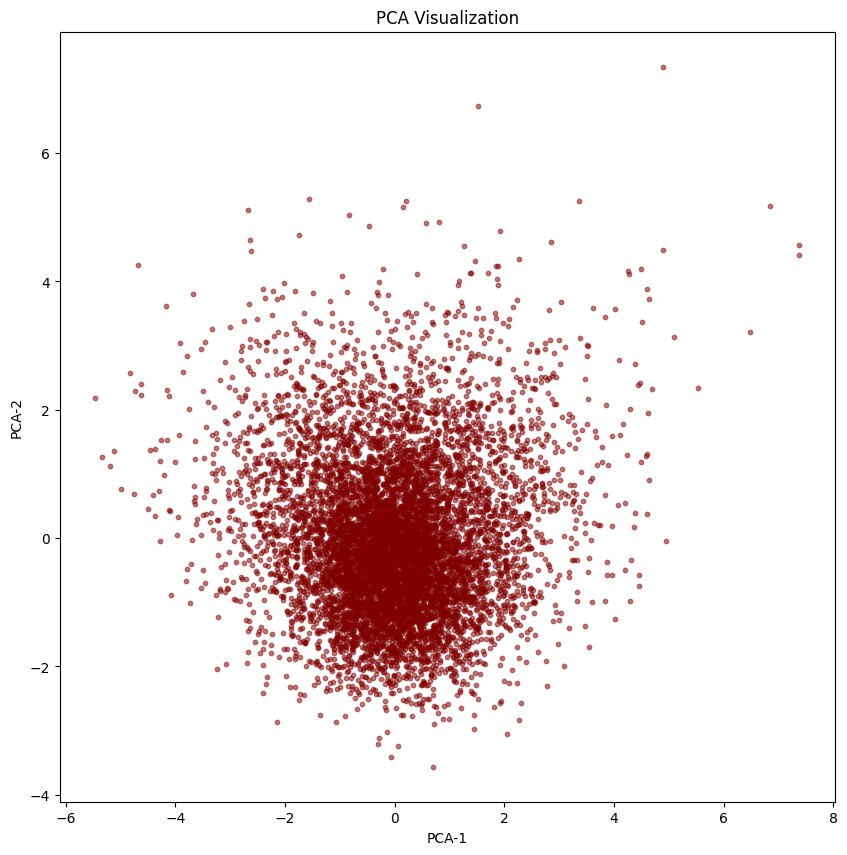

In [226]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(d2v_df)

d2v_df_PCA = pd.DataFrame(pca_mdl, columns=["x", "y"], index=d2v_df.index)

fig = plt.figure(figsize=(10, 10))

plt.scatter(x=d2v_df_PCA["x"], y=d2v_df_PCA["y"], s=10, color="maroon", alpha=0.5)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PCA Visualization")
plt.plot()
plt.show()

In [227]:
tsne_results = tsne.fit_transform(d2v_df)

d2v_tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])

d2v_tsne_df["label"] = d2v_df.index

d2v_tsne_df.head()

x          y    label
0 -8.995375 -15.910731    going
1  4.944648   4.295352  project
2 -5.212982   1.206523     time
3  0.796001  -8.819022    thats
4  5.330904  -7.799179   people

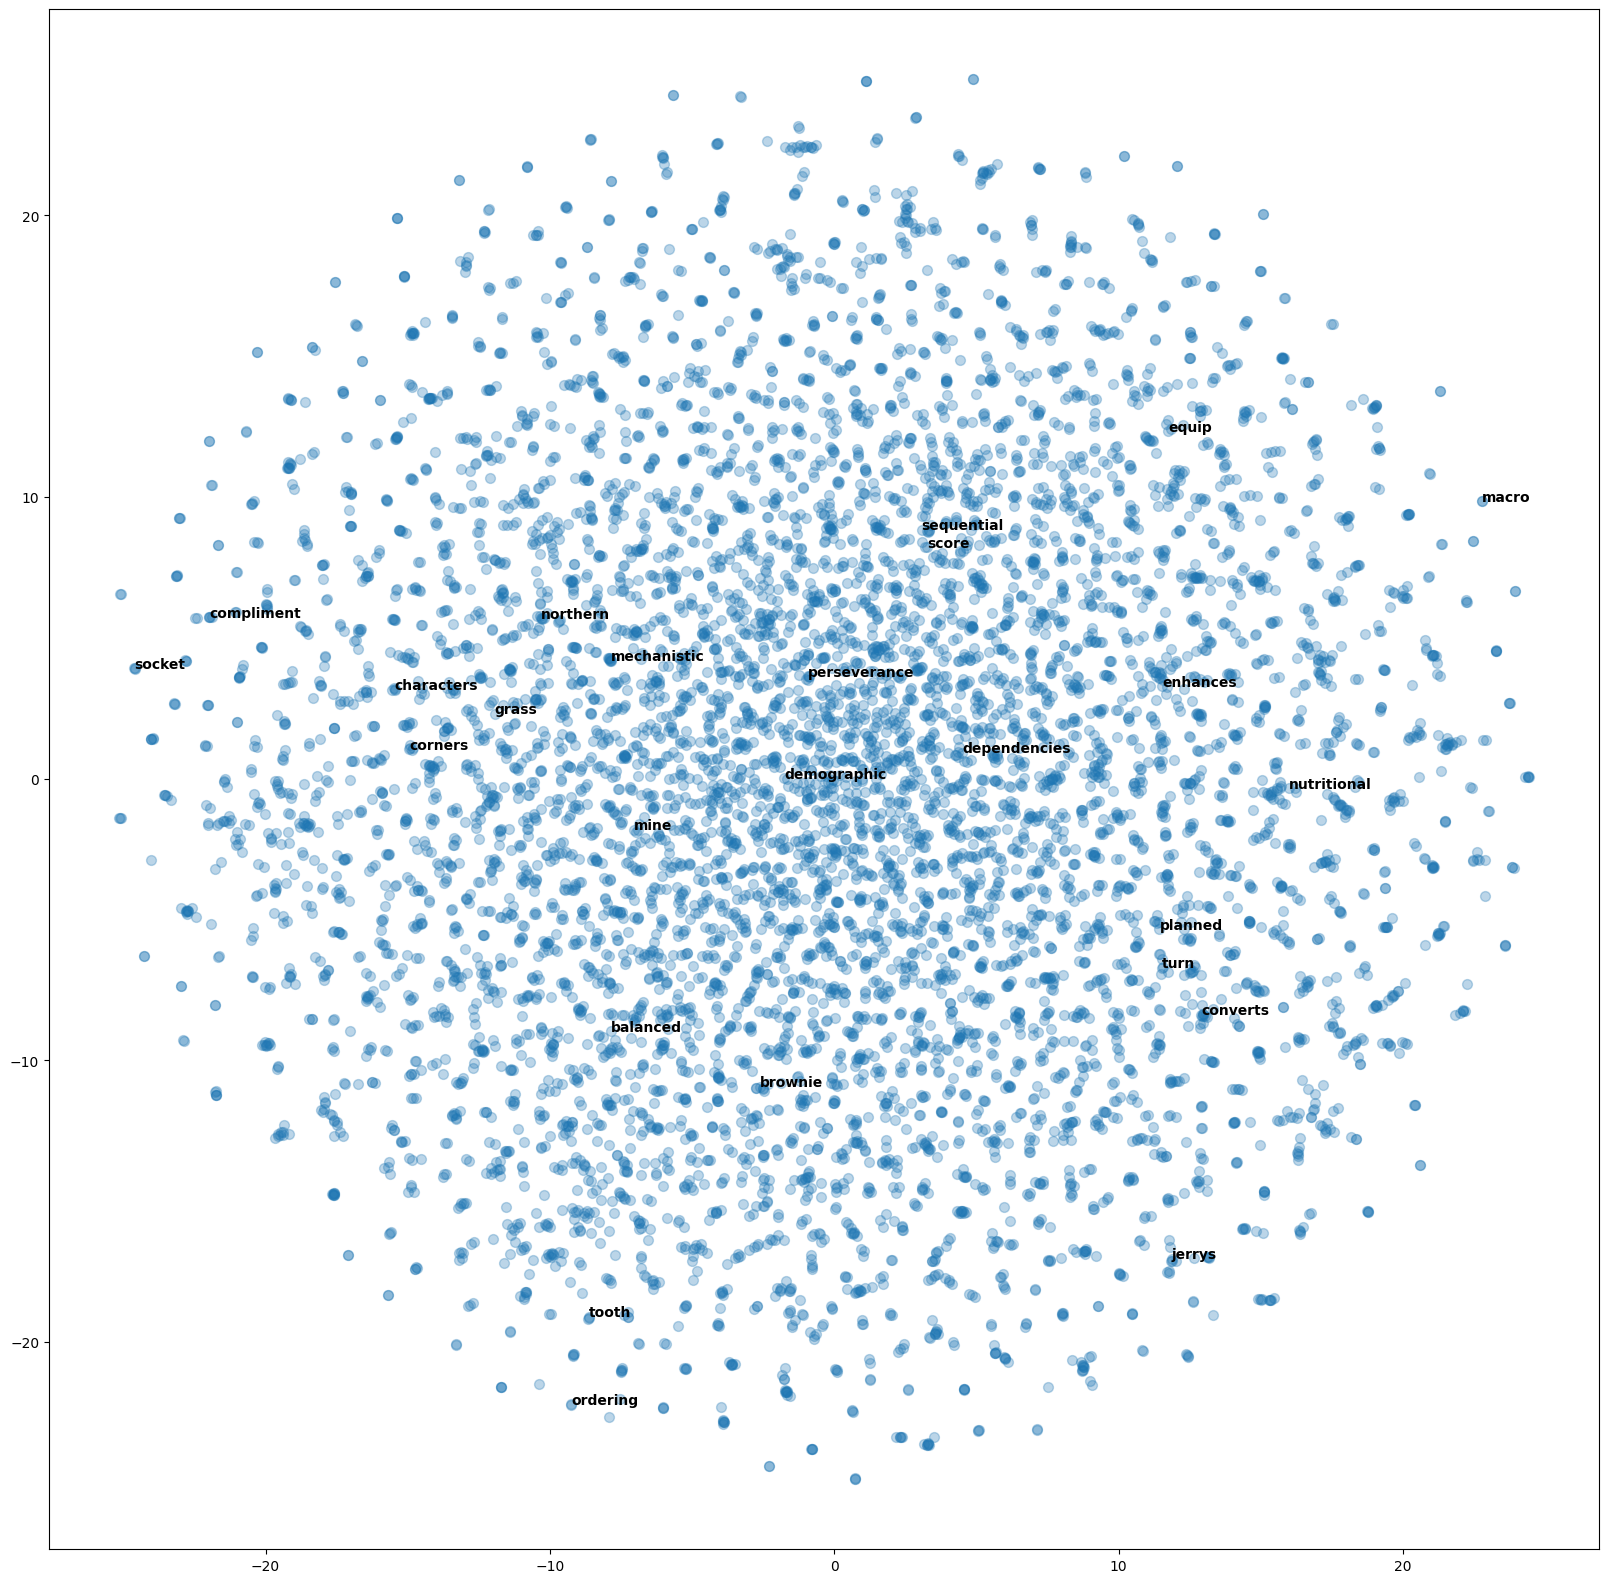

In [228]:
plt.figure(figsize=(20, 20))
plt.scatter(d2v_tsne_df.x, d2v_tsne_df.y, s=50, alpha=0.3)

annot_array = np.random.choice(d2v_tsne_df.index, 25, replace=False)

for i in annot_array:
    plt.text(
        s=d2v_tsne_df.label[i],
        x=d2v_tsne_df.x[i],
        y=d2v_tsne_df.y[i],
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )

plt.show()

### Comparing Doc2Vec and Word2Vec


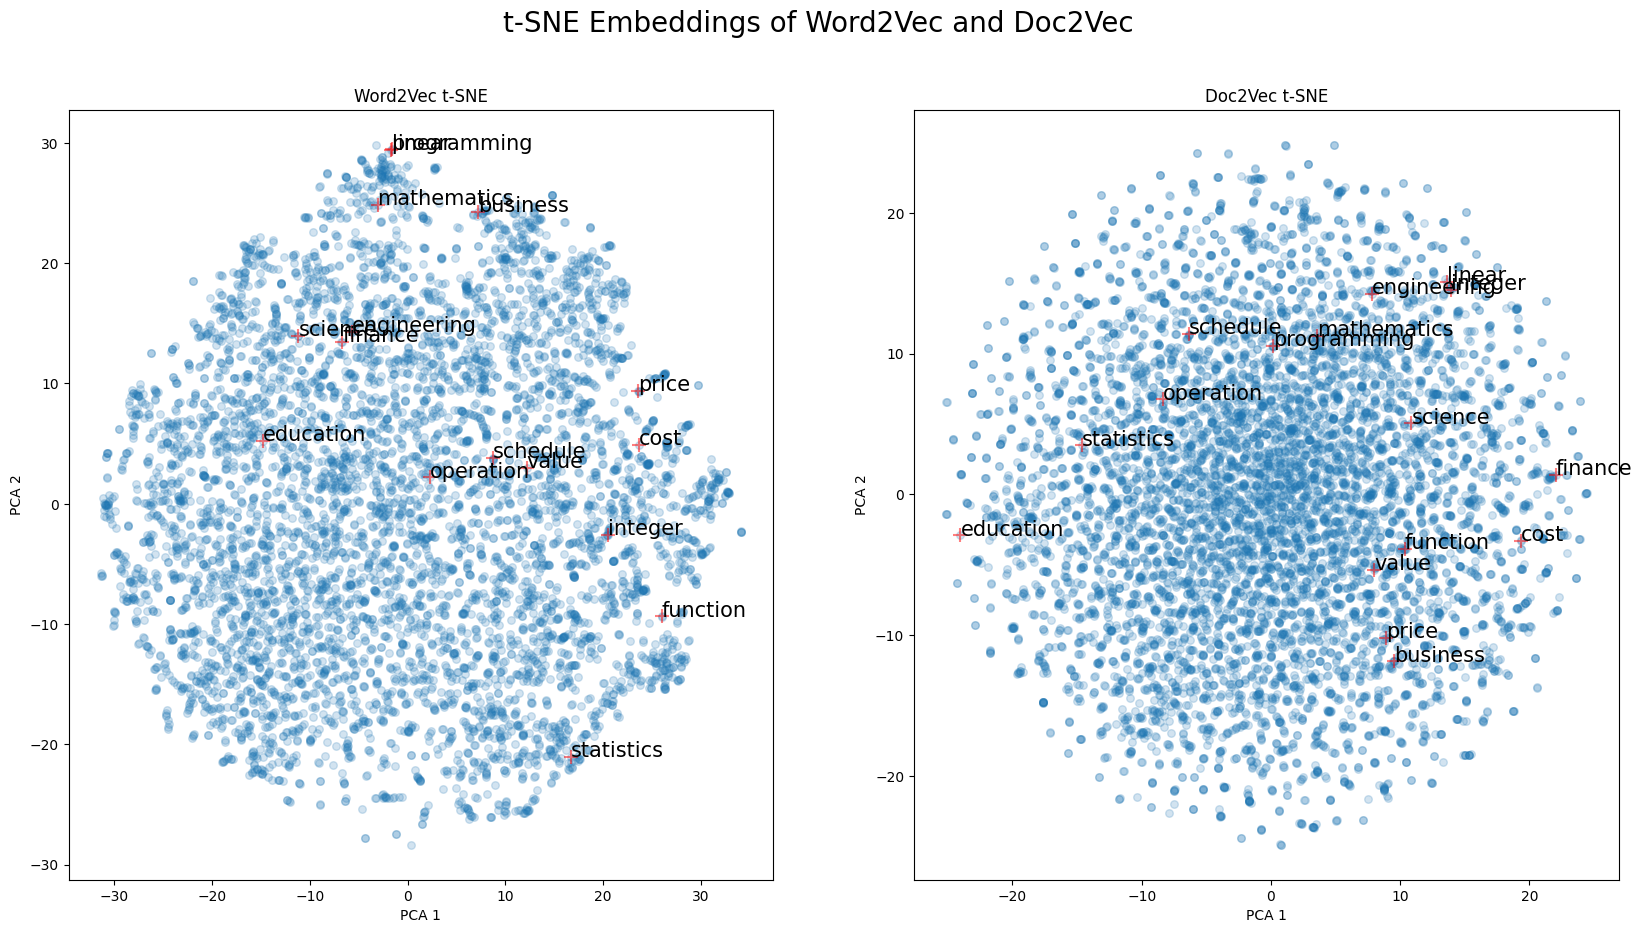

In [229]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[1].scatter(d2v_tsne_df.x, d2v_tsne_df.y, s=30, alpha=0.2)
ax[1].set_title("Doc2Vec t-SNE")
ax[1].set_xlabel("PCA 1")
ax[1].set_ylabel("PCA 2")

ax[0].scatter(tsne_df.x, tsne_df.y, s=30, alpha=0.2)
ax[0].set_title("Word2Vec t-SNE")
ax[0].set_xlabel("PCA 1")
ax[0].set_ylabel("PCA 2")

d2v_indices = []
w2v_indices = []

targets = [
    "finance",
    "mathematics",
    "statistics",
    "science",
    "programming",
    "engineering",
    "education",
    "business",
    "price",
    "value",
    "schedule",
    "operation",
    "cost",
    "function",
    "linear",
    "integer",
]

for target in targets:
    d2v_indices.append(d2v_tsne_df.label.to_list().index(target))
    w2v_indices.append(tsne_df.label.to_list().index(target))

for ind, elm in enumerate(d2v_indices):
    ax[1].text(s=targets[ind], x=d2v_tsne_df.x[elm], y=d2v_tsne_df.y[elm], fontsize=15)
    ax[1].scatter(
        d2v_tsne_df.x[elm], d2v_tsne_df.y[elm], s=100, alpha=0.5, c="red", marker="+"
    )


for ind, elm in enumerate(w2v_indices):
    ax[0].text(s=targets[ind], x=tsne_df.x[elm], y=tsne_df.y[elm], fontsize=15)
    ax[0].scatter(tsne_df.x[elm], tsne_df.y[elm], s=100, alpha=0.5, c="red", marker="+")

plt.suptitle("t-SNE Embeddings of Word2Vec and Doc2Vec", fontsize=20)
plt.show()

## BERT


### Embedding module names only


In [230]:
from sklearn.linear_model import LogisticRegression
import transformers
import torch

corpus = data.copy()
model_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)


def embed(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
    with torch.no_grad():
        output = model(input_ids)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.numpy()


embeddings = [embed(doc) for doc in corpus.name]

X = pd.DataFrame(embeddings)
y = data.cluster

clf = LogisticRegression().fit(X, y)

new_doc = [
    "Corporate Finance",
    "Project Management for Business Professionals",
    "Marketing Management",
    "Network Security",
    "Data Science and Machine Learning",
    "Data Visualization",
    "Cloud Computational Architecture",
    "Linear Algebra",
    "Calculus",
    "Statistics",
    "Data Mining",
    "Computer Architecture",
    "Problem Solving and Programming",
    "Data Structures and Algorithms",
    "Operating Systems",
    "Computer Networks",
    "Database Management Systems",
]
new_embeddings = [embed(doc) for doc in new_doc]
X_new = pd.DataFrame(new_embeddings)

predicted = clf.predict(X_new)
proba = clf.predict_proba(X_new)
accuracy = clf.score(X, y)
f1 = f1_score(y, clf.predict(X), average="weighted", zero_division=0)
recall = recall_score(y, clf.predict(X), average="weighted", zero_division=0)
precision = precision_score(y, clf.predict(X), average="weighted", zero_division=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/dpapp/Projects/emse-mms/emse-mms/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to conver

In [231]:
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")

Accuracy: 99.36%
Precision: 99.04%
Recall: 99.36%
F1: 99.15%


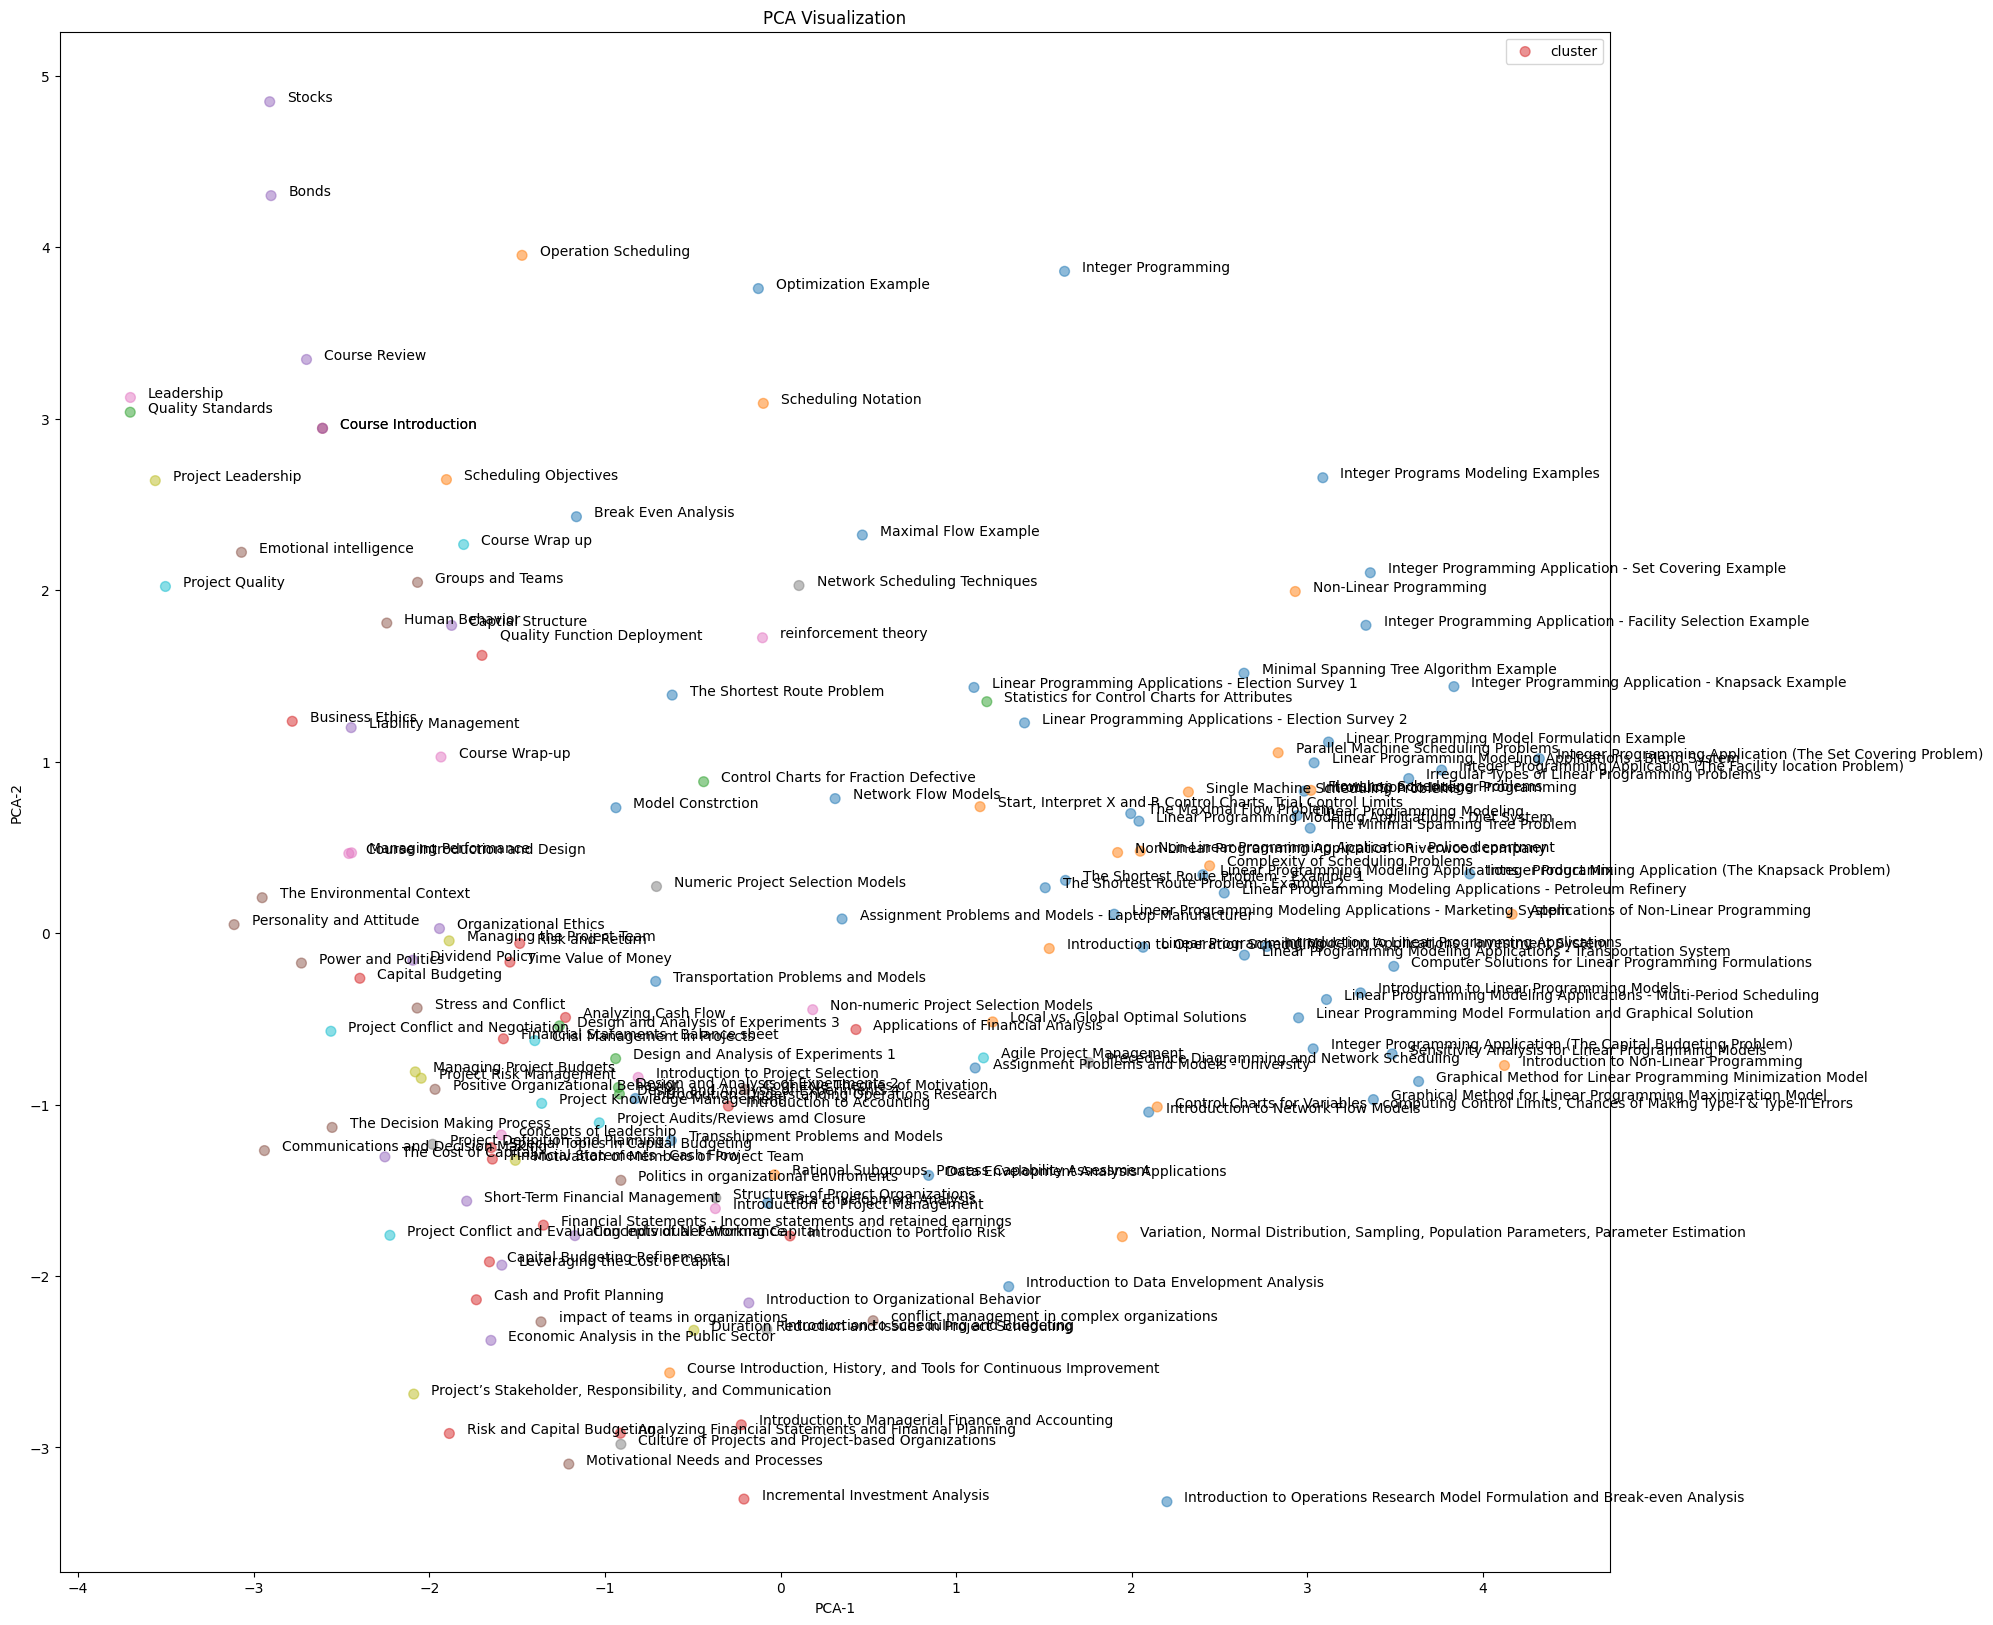

In [232]:
X.index = data.name.values

pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(X)

bert_df_PCA = pd.DataFrame(pca_mdl, columns=["x", "y"], index=X.index)

# use the data dataframe to add the cluster column to the bert_df_PCA dataframe based on the name column
bert_df_PCA["cluster"] = data.cluster.values

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(
    data=bert_df_PCA,
    x="x",
    y="y",
    s=50,
    cmap="tab10",
    alpha=0.5,
    c="cluster",
    label="cluster",
)

for i, txt in enumerate(bert_df_PCA.index):
    ax.annotate(txt, (bert_df_PCA["x"][i] + 0.1, bert_df_PCA["y"][i]))

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PCA Visualization")
plt.legend()
plt.plot()
plt.show()

In [233]:
le = LabelEncoder()

X_new.index = new_doc

pca = PCA(n_components=2, random_state=7)
pca_mdl_new = pca.fit_transform(X_new)

bert_df_PCA_new = pd.DataFrame(pca_mdl_new, columns=["x", "y"], index=X_new.index)

le.fit(new_doc)

# use the data dataframe to add the cluster column to the bert_df_PCA dataframe based on the name column
bert_df_PCA_new["cluster"] = le.transform(new_doc)

bert_df_PCA["label"] = bert_df_PCA.index

bert_df_PCA_new["label"] = bert_df_PCA_new.index

bert_df_PCA_new.reset_index(drop=True, inplace=True)

bert_df_PCA.reset_index(drop=True, inplace=True)

In [234]:
bert_df_PCA_new.head()

x         y  cluster                                          label
0  1.884116  2.455001        4                              Corporate Finance
1 -1.279360  4.864042       15  Project Management for Business Professionals
2  1.554327  3.195438       11                           Marketing Management
3  2.092883 -0.380956       12                               Network Security
4 -3.979825 -1.384029        6              Data Science and Machine Learning

In [235]:
bert_df_PCA.head()

x         y  cluster  \
0 -2.608190  2.943478       24   
1 -2.780559  1.234843       25   
2 -0.223219 -2.868006       26   
3 -0.296708 -1.009123       26   
4 -1.350444 -1.703672       26   

                                               label  
0                                Course Introduction  
1                                    Business Ethics  
2  Introduction to Managerial Finance and Accounting  
3                         Introduction to Accounting  
4  Financial Statements - Income statements and r...

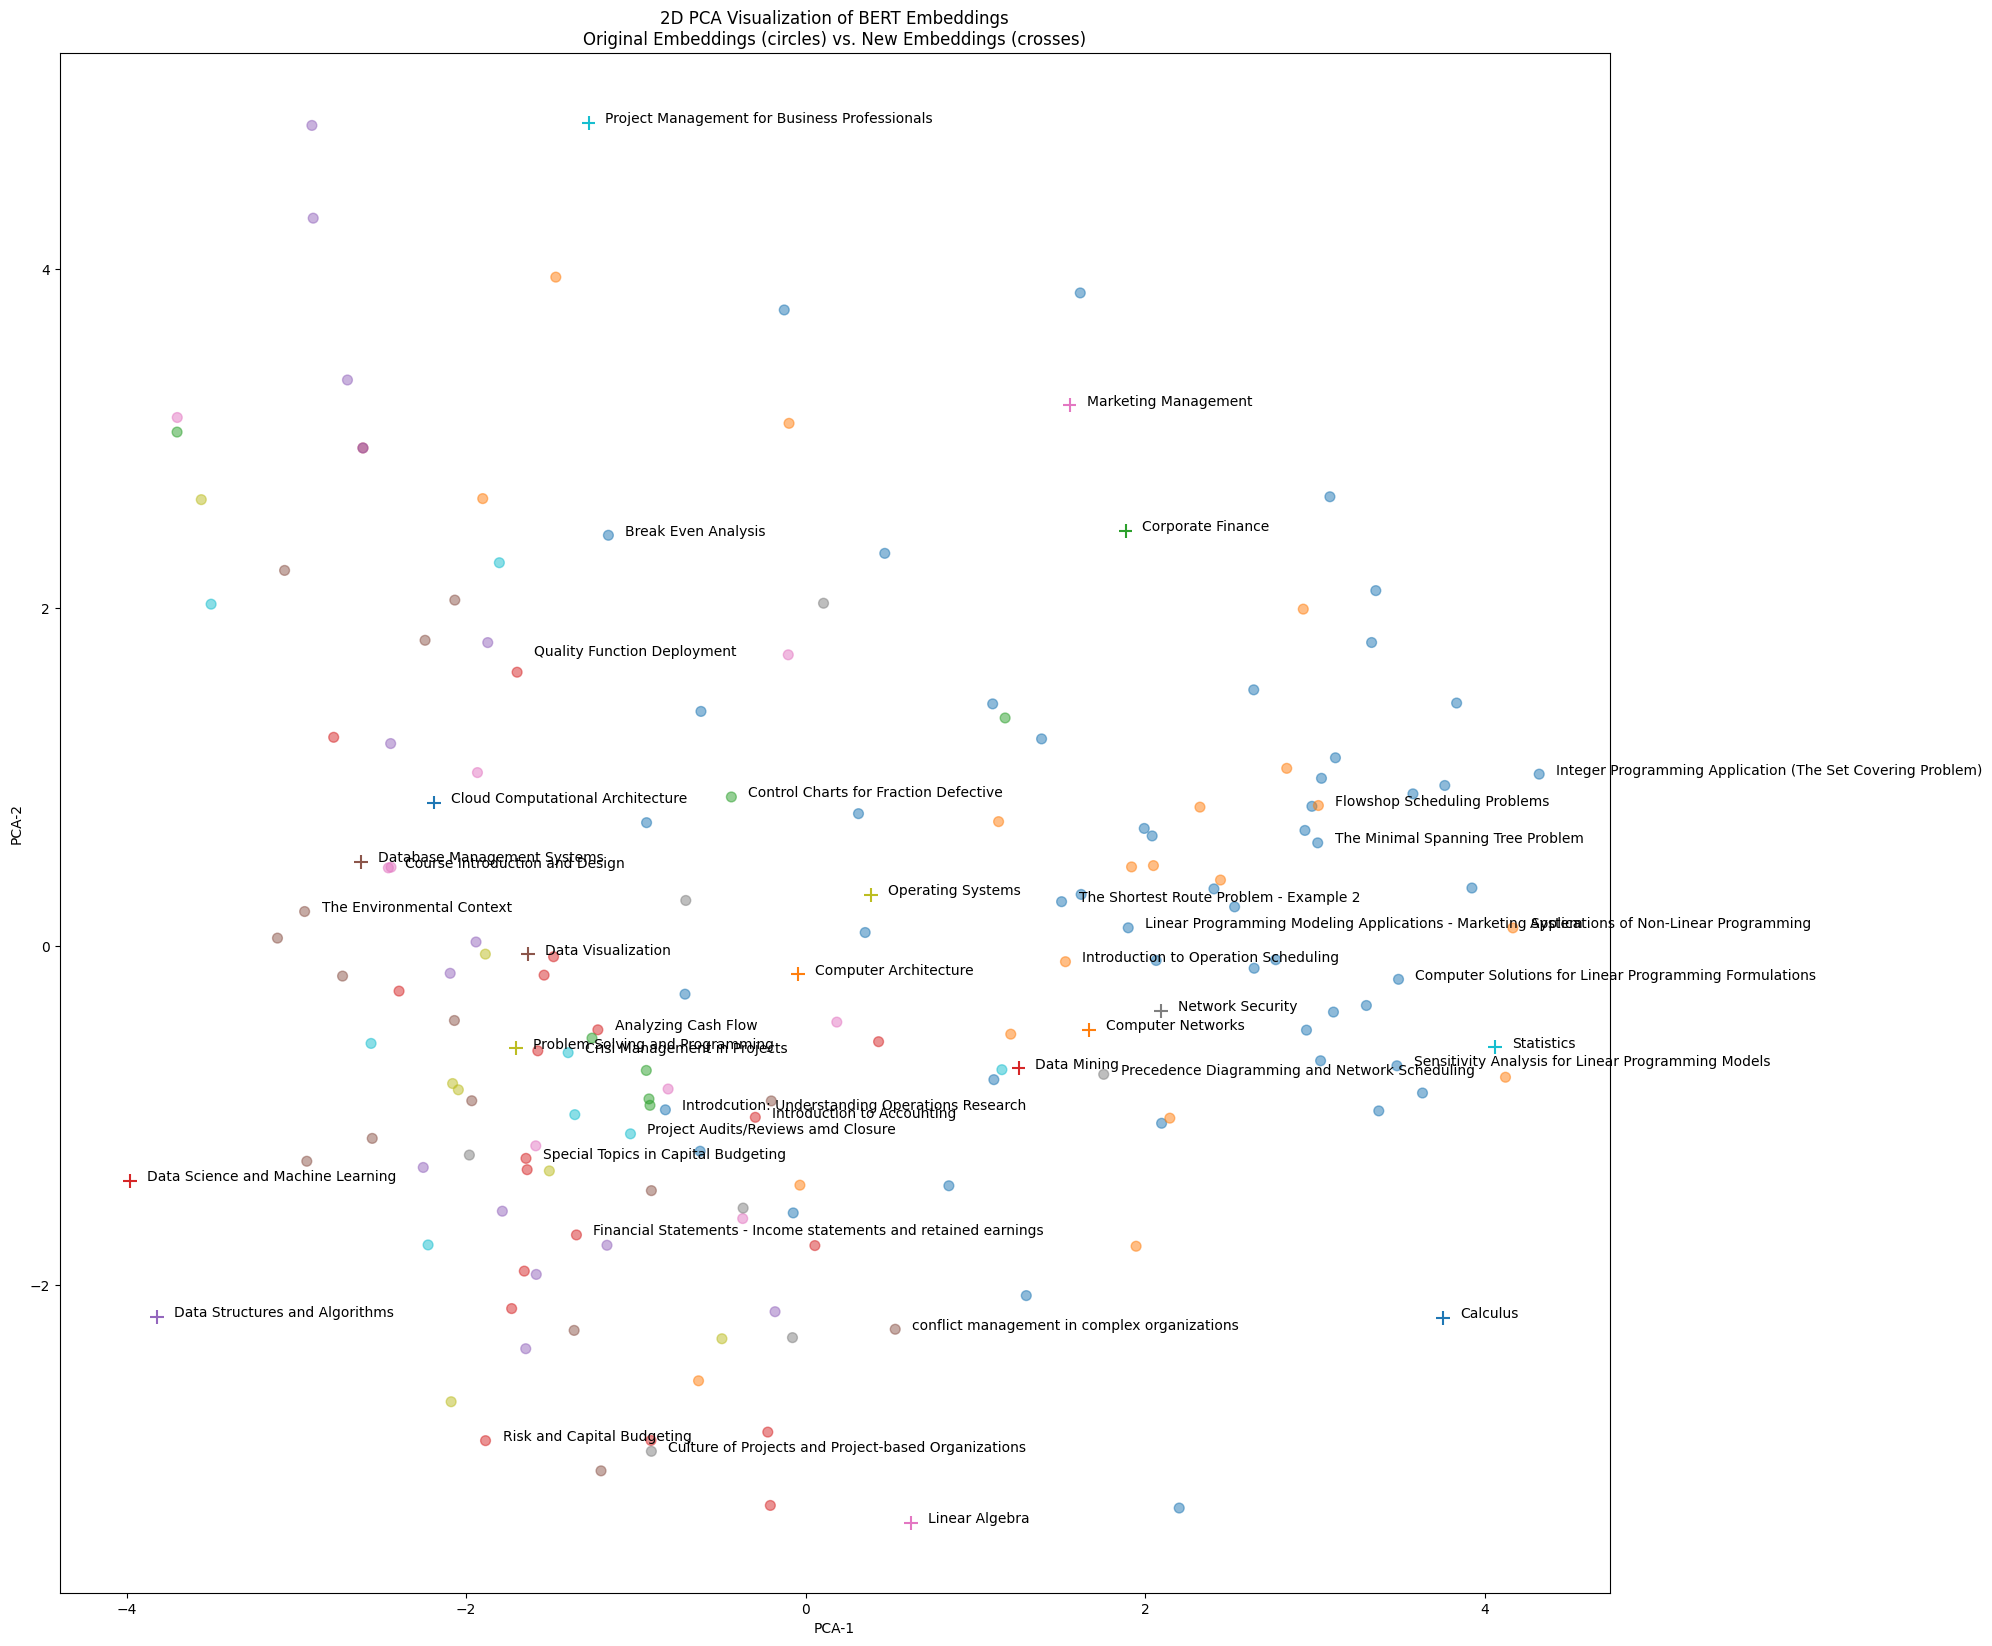

In [236]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(
    data=bert_df_PCA,
    x="x",
    y="y",
    s=50,
    cmap="tab10",
    alpha=0.5,
    c="cluster",
)

ax.scatter(
    data=bert_df_PCA_new, x="x", y="y", s=100, cmap="tab10", c="cluster", marker="+"
)

annot_array_bert = np.random.choice(bert_df_PCA.index, 25, replace=False)

for i, txt in enumerate(bert_df_PCA_new.index):
    ax.annotate(
        bert_df_PCA_new["label"][i],
        (bert_df_PCA_new["x"][i] + 0.1, bert_df_PCA_new["y"][i]),
    )

for r in annot_array_bert:
    ax.annotate(
        bert_df_PCA["label"][r], (bert_df_PCA["x"][r] + 0.1, bert_df_PCA["y"][r])
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(
    "2D PCA Visualization of BERT Embeddings\nOriginal Embeddings (circles) vs. New Embeddings (crosses)"
)
plt.show()

### Embedding combined text


In [237]:
train_data = data.copy()
model_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)


def embed(text):
    input_ids = torch.tensor(tokenizer.encode(text, truncation=True)).unsqueeze(0)
    with torch.no_grad():
        output = model(input_ids)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.numpy()


vocab = []
vocab_cluster = []
vocab_label = []

for row in train_data.iterrows():
    sentence = ""
    for element in row[1]["combined"]:
        sentence += str(element) + " "

    vocab.append(sentence)
    vocab_cluster.append(row[1]["cluster"])
    vocab_label.append(row[1]["name"])

vocab = pd.DataFrame({"vocab": vocab, "cluster": vocab_cluster, "label": vocab_label})

embeddings = [embed(doc) for doc in vocab.vocab]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [238]:
new_doc = [
    "Corporate Finance: This course delves into the financial decisions and strategies that corporations make to optimize their capital structure, investment projects, and risk management. Students learn about valuation methods, capital budgeting, risk analysis, and financial markets' impact on a company's financial health.",
    "Project Management for Business Professionals: In this course, students gain a comprehensive understanding of project management techniques, including planning, execution, monitoring, and closing of projects within a business context. The course covers topics such as project scope, time management, resource allocation, communication, and stakeholder engagement to ensure successful project delivery.",
    "Marketing Management: Marketing Management explores the principles of creating, promoting, and delivering value to customers, encompassing market analysis, consumer behavior, branding, and market segmentation. Students learn to design effective marketing strategies, utilize various marketing channels, and adapt to the ever-changing landscape of consumer preferences.",
    "Network Security: This course focuses on safeguarding digital communication networks from cyber threats by covering encryption, authentication, intrusion detection, and security protocols. Students gain insights into the techniques used by hackers and learn countermeasures to secure networks and data from unauthorized access and cyberattacks.",
    "Data Science and Machine Learning: Data Science and Machine Learning explore the process of deriving insights and making predictions from large datasets using algorithms and statistical models. Students delve into data preprocessing, feature engineering, model selection, and evaluation, enabling them to build machine learning models for various applications.",
    "Data Visualization: This course emphasizes the effective representation of data through graphs, charts, and interactive visuals to convey insights and patterns in a compelling and accessible manner. Students learn about visualization principles, tools, and techniques to communicate complex data stories to diverse audiences.",
    "Cloud Computational Architecture: Cloud Computational Architecture covers the design and management of scalable and reliable cloud-based systems, including virtualization, distributed computing, and cloud service models. Students explore cloud architecture patterns, deployment strategies, and technologies that enable businesses to leverage the flexibility and efficiency of cloud computing.",
    "Linear Algebra: Linear Algebra deals with vector spaces, linear transformations, and matrices, forming the foundation for various fields such as computer graphics, physics, and machine learning. Students learn about solving systems of linear equations, eigenvalues, eigenvectors, and applications in solving real-world problems.",
    "Calculus: Calculus introduces fundamental concepts of limits, derivatives, and integrals, providing tools to analyze change and motion in mathematics, science, and engineering. Students explore differential and integral calculus, uncovering relationships between functions and their rates of change or accumulation.",
    "Statistics: Statistics involves collecting, analyzing, and interpreting data to make informed decisions and predictions, covering topics like probability, hypothesis testing, and regression analysis. Students acquire skills in designing experiments, summarizing data, and drawing meaningful conclusions from a wide range of contexts.",
    "Data Mining: Data Mining focuses on discovering patterns, relationships, and insights from large datasets through techniques like clustering, association rule mining, and anomaly detection. Students learn to identify hidden patterns in diverse data sources, enabling informed decision-making and predictive modeling.",
    "Computer Architecture: Computer Architecture explores the design and organization of computer systems, including the central processing unit, memory hierarchy, and instruction set architecture. Students study the trade-offs between performance, energy efficiency, and cost in designing hardware components that form the basis of modern computing.",
    "Problem Solving and Programming: This course teaches the fundamentals of algorithmic problem-solving and programming, enabling students to design, implement, and debug software solutions. Students learn programming concepts, control structures, and data types to develop the skills necessary for software development and computational thinking.",
    "Data Structures and Algorithms: Data Structures and Algorithms focus on organizing and processing data efficiently, covering topics like arrays, linked lists, sorting algorithms, and search techniques. Students gain insights into selecting appropriate data structures and designing algorithms to solve computational problems in various domains.",
    "Operating Systems: Operating Systems delve into the management of computer hardware and software resources, including process management, memory allocation, and file systems. Students explore the role of operating systems in providing a stable and secure environment for software applications to run and communicate with hardware.",
    "Computer Networks: Computer Networks examine the principles of data communication and network architecture, including protocols, routing, network layers, and internet technologies. Students learn about designing, implementing, and maintaining network infrastructures that enable seamless data exchange across diverse devices and locations.",
    "Database Management Systems: Database Management Systems cover the design, implementation, and management of databases to store, retrieve, and manipulate structured data efficiently. Students study database models, normalization, SQL queries, and transaction management to ensure data integrity and support information-centric applications.",
]

In [239]:
X = pd.DataFrame(embeddings)
y = vocab.cluster

clf = LogisticRegression().fit(X, y)

new_doc_names = [
    "Corporate Finance",
    "Project Management for Business Professionals",
    "Marketing Management",
    "Network Security",
    "Data Science and Machine Learning",
    "Data Visualization",
    "Cloud Computational Architecture",
    "Linear Algebra",
    "Calculus",
    "Statistics",
    "Data Mining",
    "Computer Architecture",
    "Problem Solving and Programming",
    "Data Structures and Algorithms",
    "Operating Systems",
    "Computer Networks",
    "Database Management Systems",
]

new_embeddings = [embed(doc) for doc in new_doc]
X_new = pd.DataFrame(new_embeddings)

predicted = clf.predict(X_new)
proba = clf.predict_proba(X_new)
accuracy = clf.score(X, y)
f1 = f1_score(y, clf.predict(X), average="weighted", zero_division=0)
recall = recall_score(y, clf.predict(X), average="weighted", zero_division=0)
precision = precision_score(y, clf.predict(X), average="weighted", zero_division=0)

/Users/dpapp/Projects/emse-mms/emse-mms/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [240]:
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1: {f1:.2%}")

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


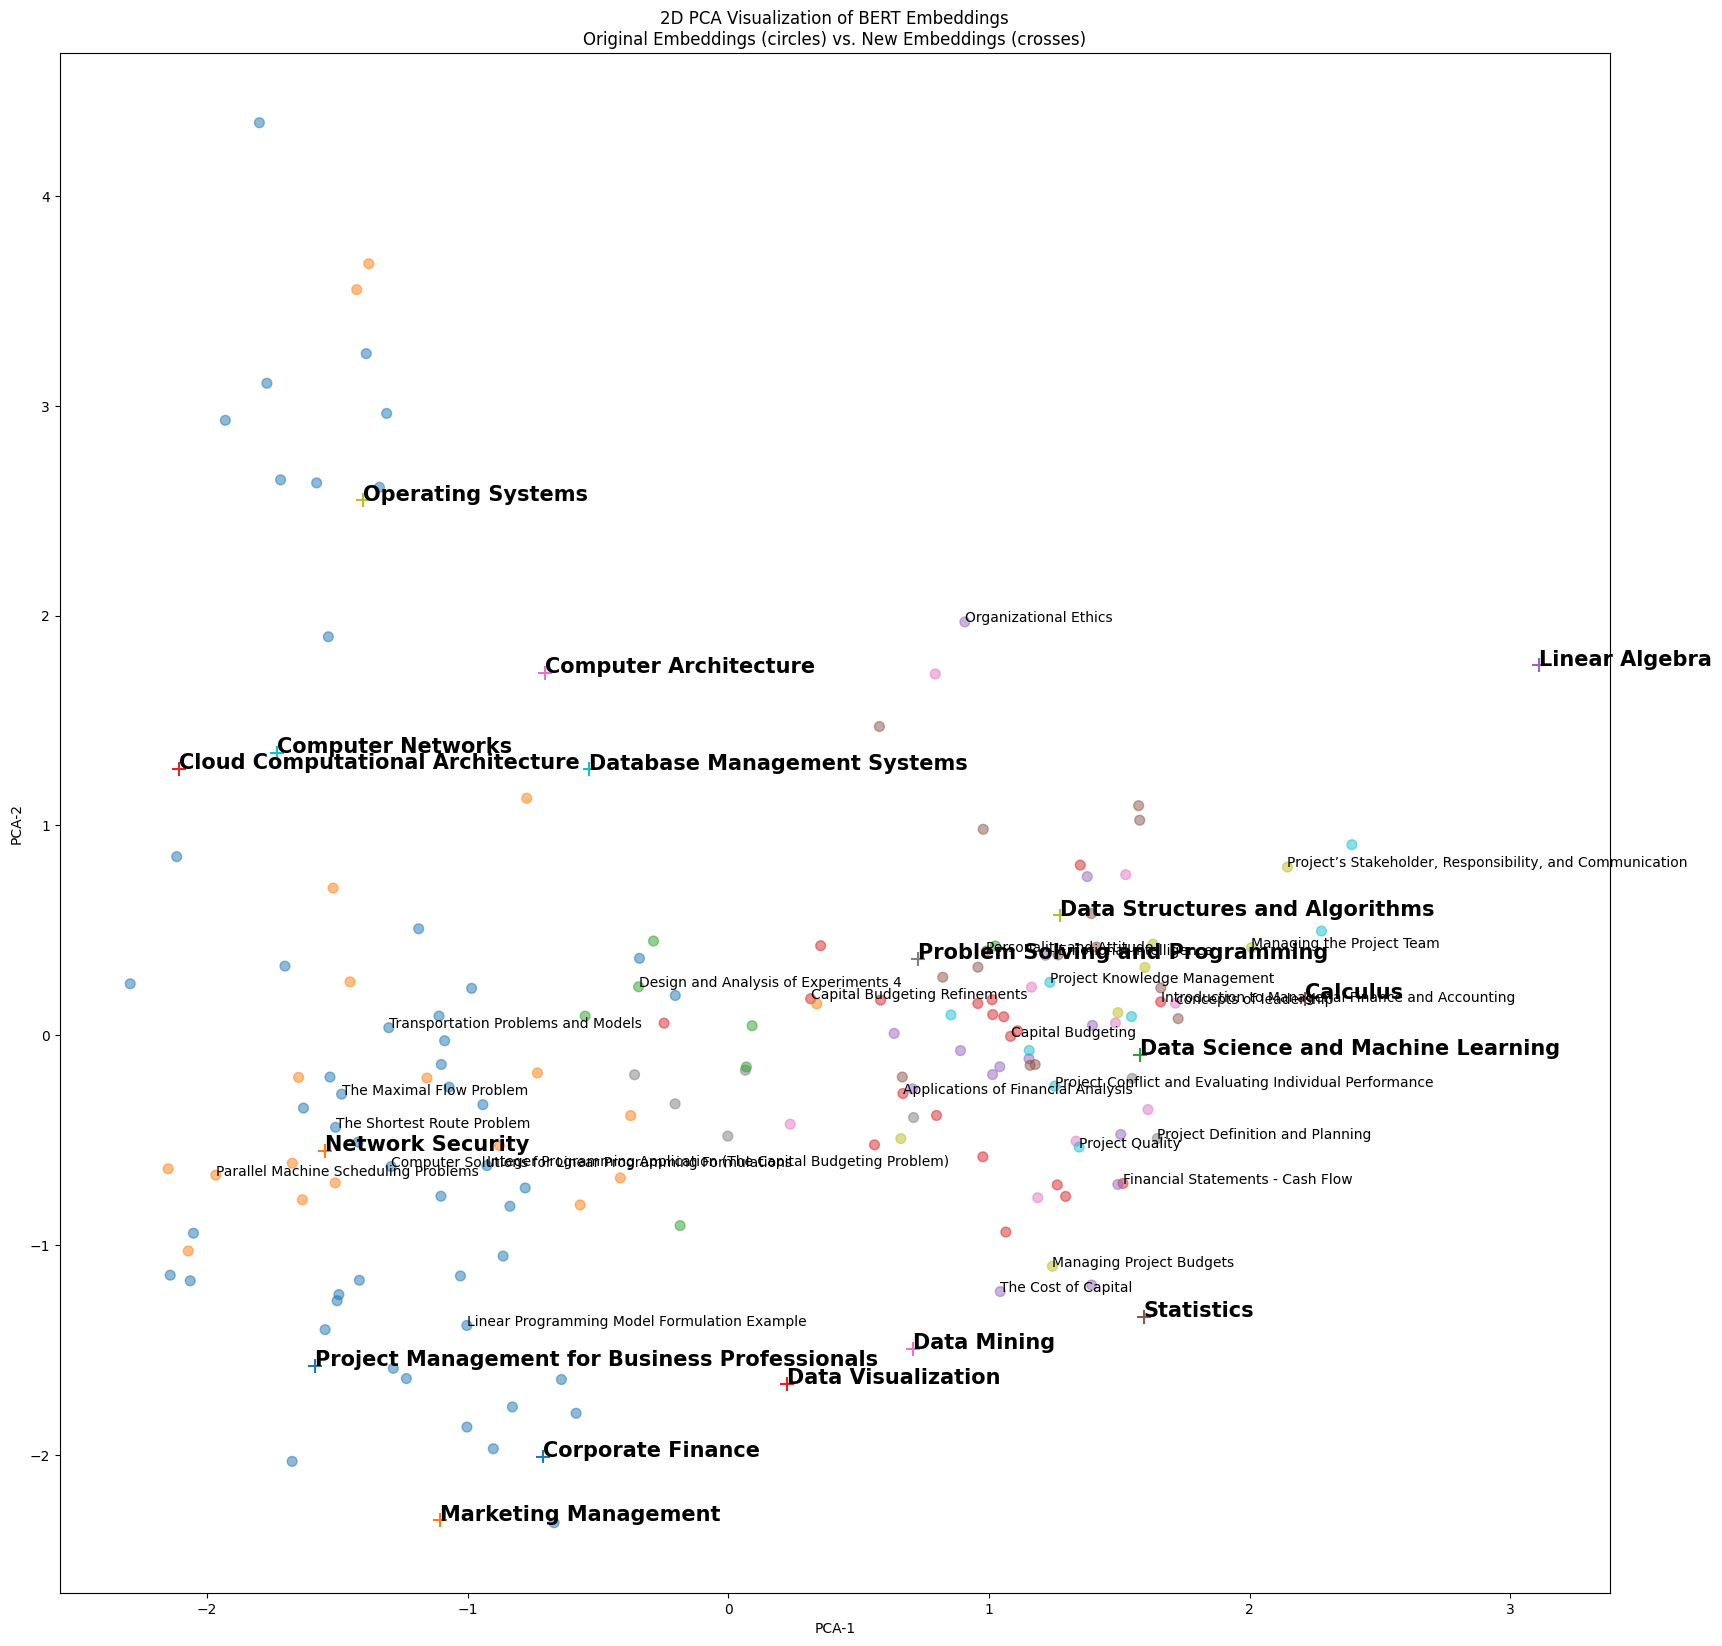

In [241]:
bert_pca = PCA(n_components=2, random_state=123)
bert_pca_x = pca.fit_transform(X)

bert_pca_df = pd.DataFrame(
    {"x": bert_pca_x[:, 0], "y": bert_pca_x[:, 1], "label": vocab.label, "cluster": y}
)

bert_pca_x_test = pca.fit_transform(X_new)

bert_pca_x_test_df = pd.DataFrame(
    {
        "x": bert_pca_x_test[:, 0],
        "y": bert_pca_x_test[:, 1],
        "label": new_doc,
        "cluster": range(len(new_doc)),
        "name": new_doc_names,
    }
)

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(
    data=bert_pca_df,
    x="x",
    y="y",
    s=50,
    cmap="tab10",
    alpha=0.5,
    c="cluster",
    marker="o",
)

ax.scatter(
    data=bert_pca_x_test_df, x="x", y="y", s=100, cmap="tab10", c="cluster", marker="+"
)

for i, txt in enumerate(bert_pca_x_test_df.index):
    ax.text(
        s=bert_pca_x_test_df["name"][i],
        x=bert_pca_x_test_df["x"][i],
        y=bert_pca_x_test_df["y"][i],
        fontdict={"fontsize": 15, "fontweight": "bold"},
    )


annot_array_bert = np.random.choice(bert_pca_df.index, 25, replace=False)

for r in annot_array_bert:
    ax.text(
        s=bert_pca_df["label"][r],
        x=bert_pca_df["x"][r],
        y=bert_pca_df["y"][r],
        fontdict={"fontsize": 10},
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(
    "2D PCA Visualization of BERT Embeddings\nOriginal Embeddings (circles) vs. New Embeddings (crosses)"
)
plt.show()

## Sent2Vec


In [242]:
import sent2vec

s2v = sent2vec.Sent2vecModel()

s2v.load_model("lib/wiki_bigrams.bin")

s2v_df: DataFrame = data.copy()
s2v_vocab: DataFrame = vocab.copy()

In [269]:
s2v_df.sample(15)

name  \
12                                     Risk and Return   
72   Linear Programming Modeling Applications - Inv...   
78           Introduction to Data Envelopment Analysis   
87   Integer Programming Application - Knapsack Exa...   
136                   Project Conflict and Negotiation   
1                                      Business Ethics   
156                      Quality Function Deployment\n   
85   Integer Programming Application (The Set Cover...   
143                                     Course Wrap up   
22                                 The Cost of Capital   
101            Minimal Spanning Tree Algorithm Example   
33                           The Environmental Context   
23                      Leveraging the Cost of Capital   
148  Rational Subgroups, Process Capability Assessment   
100                  The Minimal Spanning Tree Problem   

                                              features  \
12   In this video, the instructor introduces the c...   
72   Linear Programming Modeling Examples - Investm...   
78   In this module, we give a specific attention t...   
87   Integer Programming Application - Knapsack Exa...   
136  In module 19 of ENMA 604, we will be discussin...   
1    In this lecture on business ethics, the instru...   
156  Quality Function Deployment (QFD) is a custome...   
85   Explain the concept of Integer Programming and...   
143  Hello students! Welcome to our final module fo...   
22   In this video, the instructor delves into the ...   
101            Minimal Spanning Tree Algorithm Example   
33   The video transcript discusses the concept of ...   
23   In this video, the instructor provides a compr...   
148  In this module, we will explore the importance...   
100  Identify the types of facility location proble...   

                                            transcript  cluster  number  \
12   Greetings. In this lecture, we're going to int...       28     5.0   
72   [00:00:00:26] Let's now take another linear pr...        4     4.3   
78   [00:00:01:05] In this module, we give a specif...        5     5.0   
87   [00:00:01:26] Let's take an example of the mul...        6     6.6   
136  Hi and welcome to module 19. We are going to b...       66    19.0   
1    Greetings. Hello again. In this lecture, we'll...       25     2.0   
156  Greetings. Welcome back to ENMA 614, quality s...       23    10.0   
85   [00:00:00:19] Let's now take the set covering ...        6     6.4   
143  Hi, I'm welcome to our final Learning module m...       73    26.0   
22   Well, hello again and welcome back. In this le...       31     8.0   
101  [00:00:01:08] Let's take an exercise on the mi...        8     8.6   
33   Okay, we're back. I hope you had some time to ...       37     3.0   
23   Greetings and welcome back. In today's lecture...       31     8.1   
148  Greetings. Welcome back to ENMA 614 quality sy...       15     5.0   
100  [00:00:01:00] Let's now go over a problem know...        8     8.5   

        hours prefix                                           combined  
12   1.000000   CEFA  [title, risk, return, description, video, inst...  
72   1.100000  LP-ME  [title, linear, programming, modeling, applica...  
78   0.200000    DEA  [title, introduction, data, envelopment, analy...  
87   1.652350     IP  [title, integer, programming, knapsack, descri...  
136  0.958600     PM  [title, project, conflict, negotiation, descri...  
1    1.000000   CEFA  [title, business, ethics, description, lecture...  
156  0.866000    QSD  [title, quality, function, deployment, descrip...  
85   0.440968     IP  [title, integer, programming, set, covering, d...  
143  0.294200     PM  [title, wrap, description, hello, students, we...  
22   1.000000   CEFA  [title, cost, capital, description, video, ins...  
101  1.523000    NFM  [title, minimal, spanning, tree, algorithm, de...  
33   0.982000    ACO  [title, environmental, context, description, v...  
23   1.000000   CEFA  [title,

In [280]:
s2v_target = [
    "Capital Budgeting",
    "Risk and Return",
    "Cash and Profit Planning",
    "Agile Project Management",
    "Statistics for Control Charts for Attributes",
    "Stocks",
    "Maximal Flow Example",
    "Network Flow Models",
    "Linear Programming Modeling",
    "Project Quality",
    "Data Envelopment Analysis",
    "Bonds",
    "Cash and Profit Planning",
    "Motivational Needs and Processes",
    "The Environmental Context",
    "The Minimal Spanning Tree Problem",
]

s2v_target_indices = []

for target in s2v_target:
    s2v_target_indices.append(s2v_df.name.to_list().index(target))

In [261]:
embs_train = s2v.embed_sentences(s2v_vocab.vocab)
embs_test = s2v.embed_sentences(new_doc)

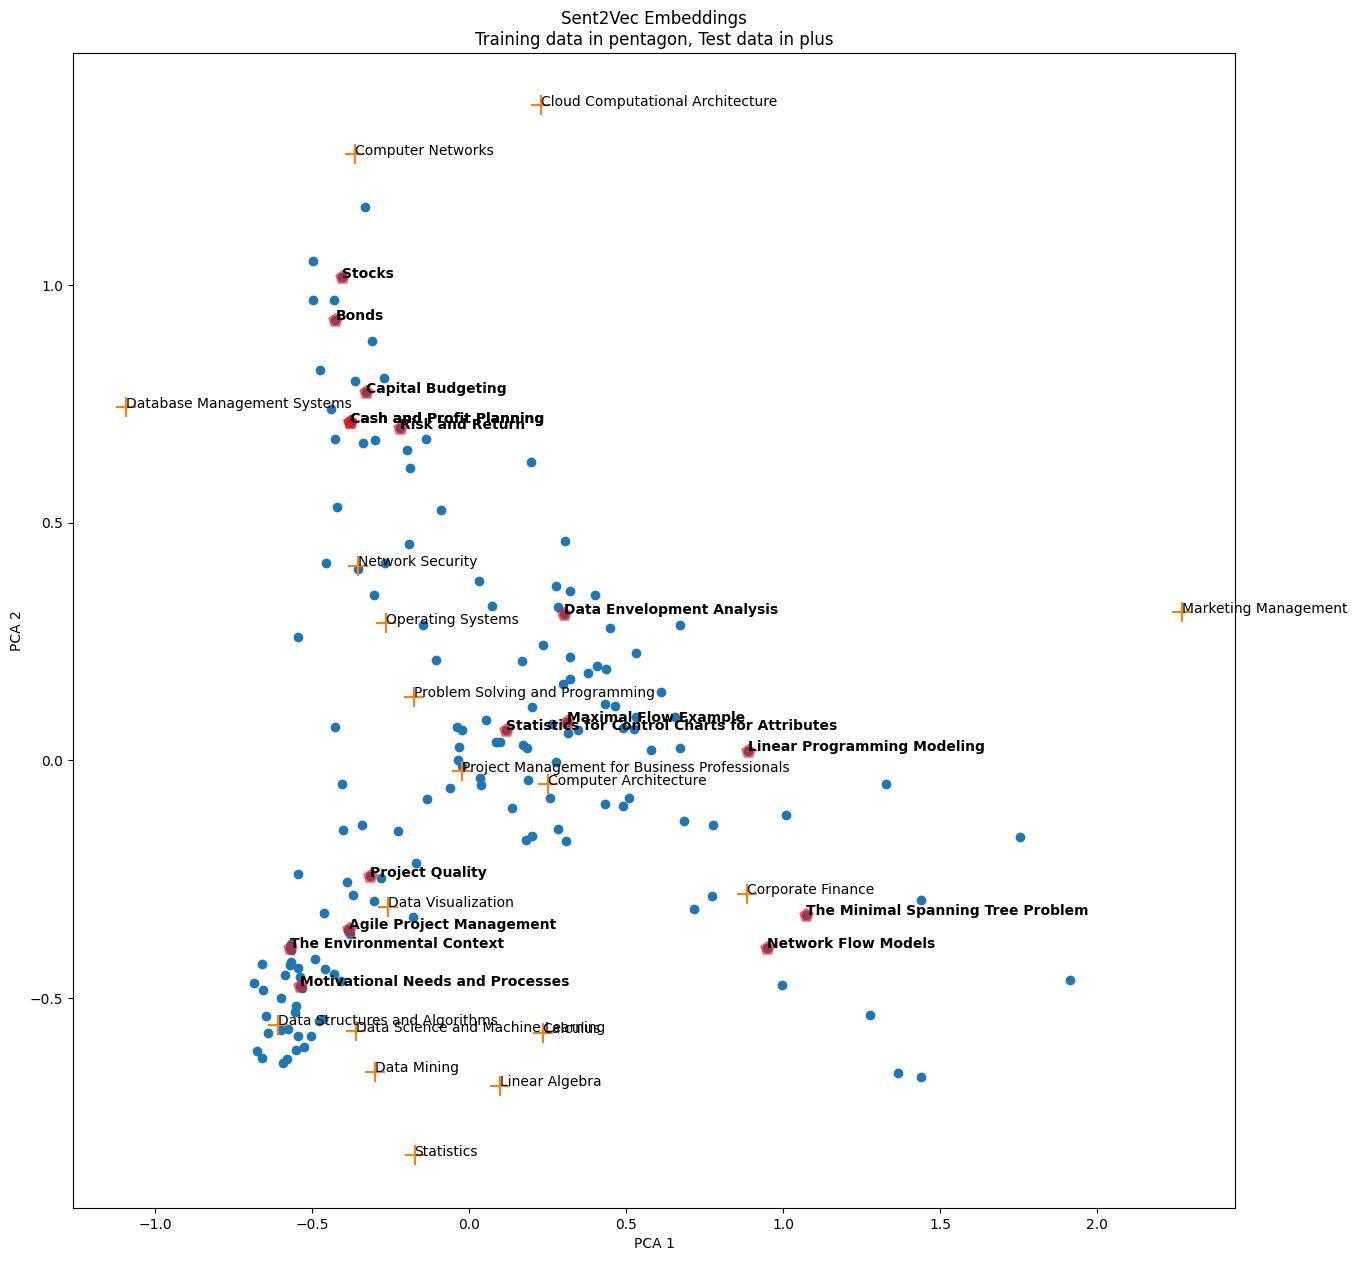

In [279]:
pca = PCA(n_components=2)

s2v_pca_train = pca.fit_transform(embs_train)

s2v_pca_df_train = pd.DataFrame(
    {
        "x": s2v_pca_train[:, 0],
        "y": s2v_pca_train[:, 1],
        "label": vocab.label,
        "cluster": vocab.cluster,
    }
)

s2v_pca_test = pca.fit_transform(embs_test)

s2v_pca_df_test = pd.DataFrame(
    {
        "x": s2v_pca_test[:, 0],
        "y": s2v_pca_test[:, 1],
        "label": new_doc_names,
        "cluster": le.transform(new_doc_names),
    }
)

fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(
    s2v_pca_df_train["x"],
    s2v_pca_df_train["y"],
    cmap="viridis",
)
ax.scatter(
    s2v_pca_df_test["x"],
    s2v_pca_df_test["y"],
    cmap="viridis",
    marker="+",
    s=200,
)
ax.set_title("Sent2Vec Embeddings\nTraining data in pentagon, Test data in plus")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

for ind, elm in enumerate(s2v_target_indices):
    ax.text(
        s=s2v_target[ind],
        x=s2v_pca_df_train["x"][elm],
        y=s2v_pca_df_train["y"][elm],
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )
    ax.scatter(
        s2v_pca_df_train["x"][elm],
        s2v_pca_df_train["y"][elm],
        s=100,
        alpha=0.5,
        c="red",
        marker="p",
    )

for row in s2v_pca_df_test.iterrows():
    ax.text(row[1]["x"], row[1]["y"], row[1]["label"])

plt.show()

### T-SNE feature reduction


In [263]:
print(embs_train.shape)
print(embs_test.shape)

(157, 700)
(17, 700)


/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_73665/1010881807.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

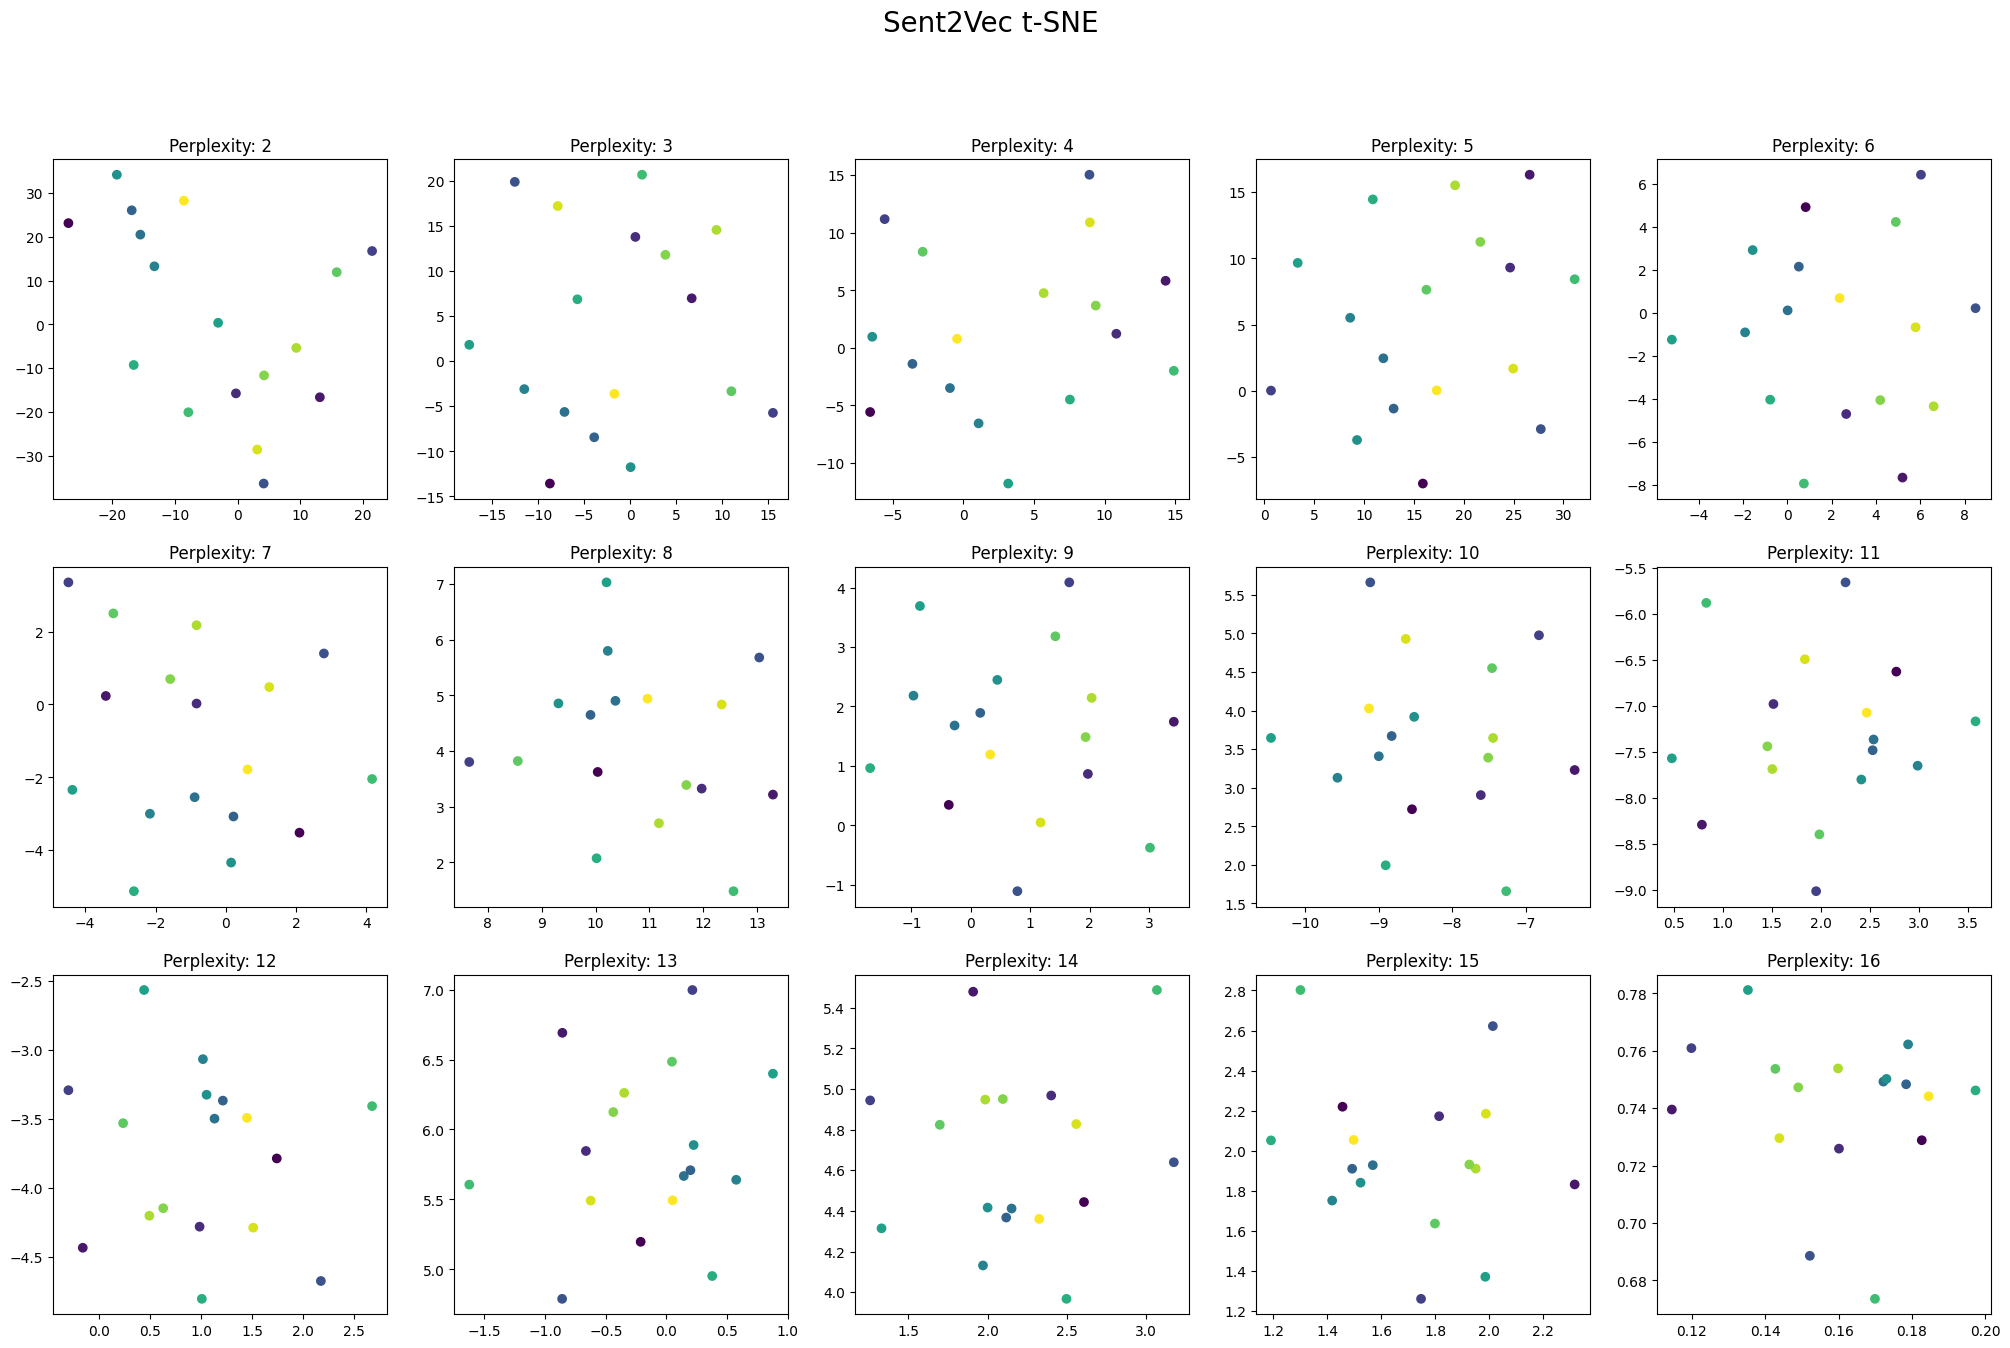

In [264]:
plt.clf()
fig, ax = plt.subplots(3, 5, figsize=(25, 15))

for ind, conf in enumerate(range(2, 17, 1)):
    s2v_tsne = TSNE(
        n_components=2, random_state=46, perplexity=conf, learning_rate=10, n_iter=5000
    )

    s2v_tsne_train = s2v_tsne.fit_transform(embs_train)

    s2v_tsne_df_train = pd.DataFrame(
        {
            "x": s2v_tsne_train[:, 0],
            "y": s2v_tsne_train[:, 1],
            "label": vocab.label,
            "cluster": vocab.cluster,
        }
    )

    s2v_tsne_test = s2v_tsne.fit_transform(embs_test)

    s2v_tsne_df_test = pd.DataFrame(
        {
            "x": s2v_tsne_test[:, 0],
            "y": s2v_tsne_test[:, 1],
            "label": new_doc_names,
            "cluster": le.transform(new_doc_names),
        }
    )

    ax[ind // 5][ind % 5].set_title(f"Perplexity: {conf}")
    ax[ind // 5][ind % 5].scatter(
        s2v_tsne_df_test["x"],
        s2v_tsne_df_test["y"],
        c=s2v_tsne_df_test["cluster"],
        cmap="viridis",
    )
    # ax[ind // 5][ind % 5].scatter(
    #     s2v_tsne_df_train["x"],
    #     s2v_tsne_df_train["y"],
    #     c=s2v_tsne_df_train["cluster"],
    #     cmap="viridis",
    #     alpha=0.5,
    #     s=10,
    # )

fig.suptitle("Sent2Vec t-SNE", fontsize=20)
fig.show()

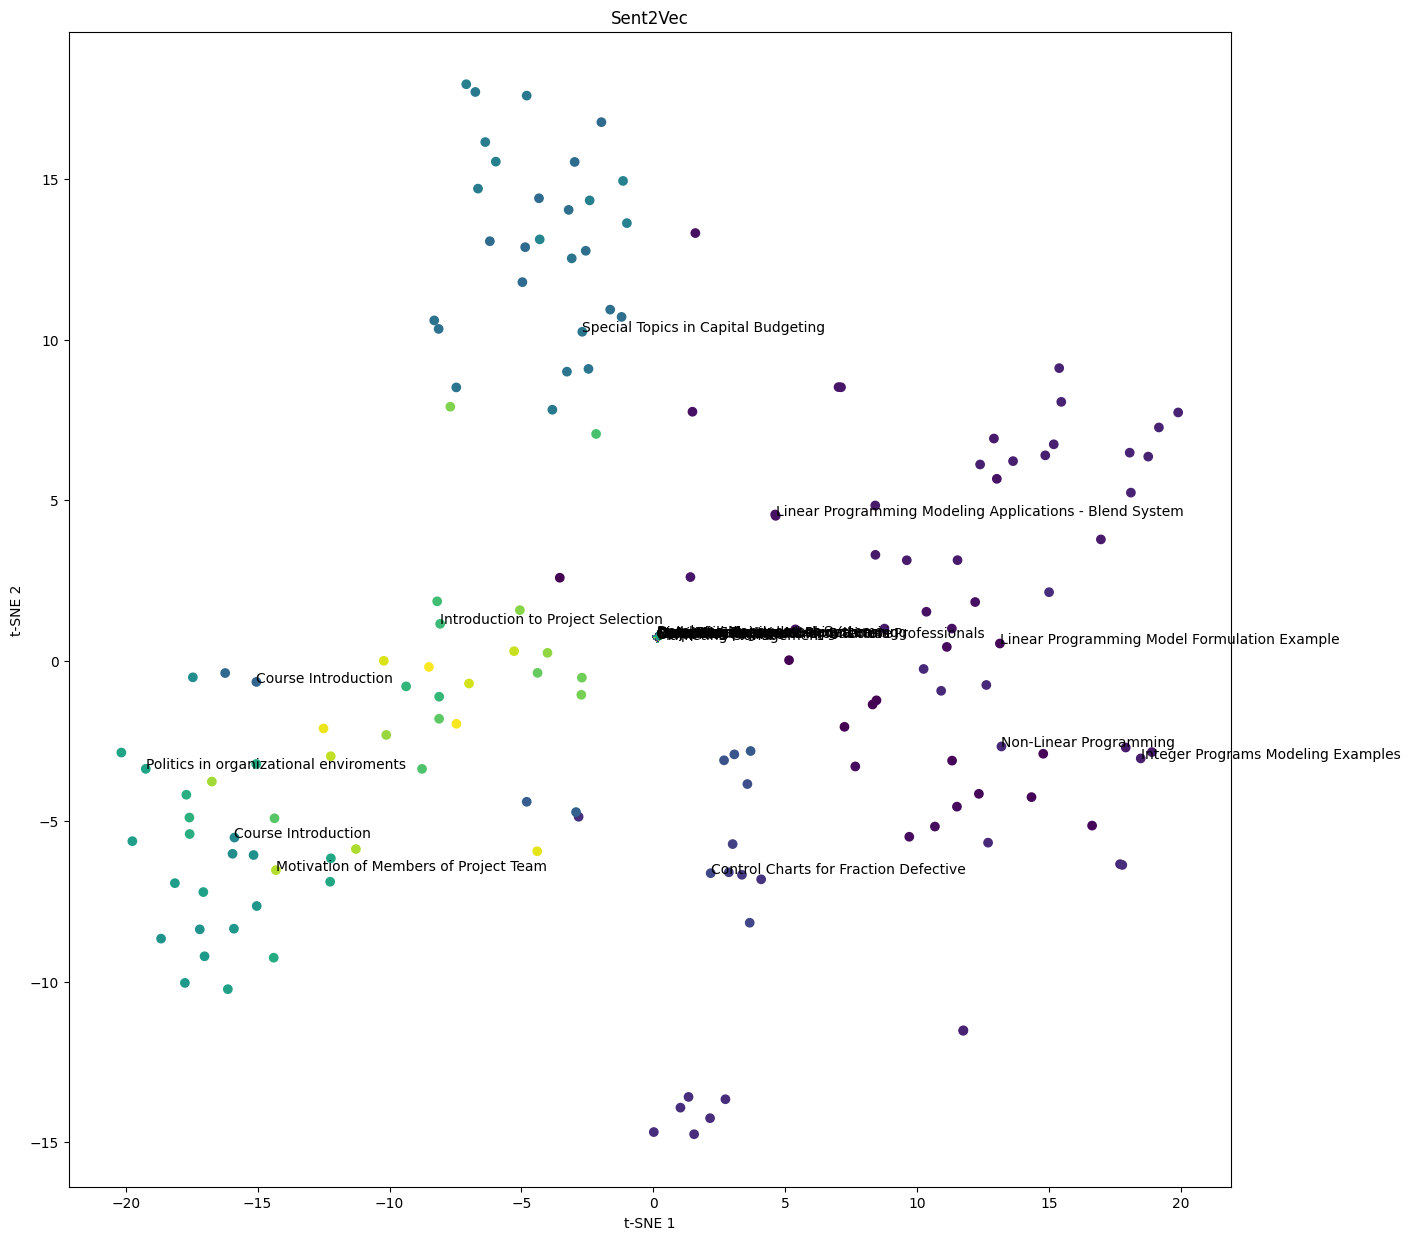

In [265]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(
    s2v_tsne_df_train["x"],
    s2v_tsne_df_train["y"],
    c=s2v_tsne_df_train["cluster"],
    cmap="viridis",
)

ax.scatter(
    s2v_tsne_df_test["x"],
    s2v_tsne_df_test["y"],
    c=s2v_tsne_df_test["cluster"],
    cmap="viridis",
    marker="+",
)

ax.set_title("Sent2Vec")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")

for row in s2v_tsne_df_train.iterrows():
    if row[0] % 15 == 0:
        ax.text(row[1]["x"], row[1]["y"], row[1]["label"])

for row in s2v_tsne_df_test.iterrows():
    ax.text(row[1]["x"], row[1]["y"], row[1]["label"])

plt.show()